In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#导入常用库
import os
print(os.getcwd())
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
#设置显示中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 无视警告
import warnings 
# warnings.filterwarnings('always') # 显示所有警告
warnings.filterwarnings('ignore') # 忽略所有警告
def auto_eda(data, column_name,n_shu=15):
    '''
    对数据列进行自动检测并执行适当的探索性数据分析(EDA)
    
    参数:
    data: pandas DataFrame 数据框
    column_name: 要分析的列名
    n_shu: 选择后续绘图分析展示的前多少个数值型特征数量，如果少于该数量，则全部展示
    
    返回:
    stats_dict: 包含该列统计信息的字典
    '''
    print("="*130)
    print("="*50,f"{column_name}的自动探索性数据分析","="*50)
    print("="*130)
    if column_name not in data.columns:
        print(f"列名 '{column_name}' 不在数据集中")
    
    if data[column_name] is None or data[column_name].isnull().all():
        print(f"⚠⚠⚠⚠列名 '{column_name}' 中数据为空!⚠⚠⚠⚠")
        return None

    
    # 创建一个字典来存储统计信息
    stats_dict = {}
    
    # 获取列数据
    col_data = data[column_name]
    
    # 获取数据类型
    dtype_name = str(col_data.dtype)
    stats_dict['数据类型'] = dtype_name
    
    # 检查缺失值
    missing_count = col_data.isnull().sum()
    missing_percent = missing_count / len(col_data) * 100
    stats_dict['缺失值数量'] = missing_count
    stats_dict['缺失值百分比'] = f"{missing_percent:.2f}%"
    
    # 检查唯一值数量
    unique_count = col_data.nunique()
    stats_dict['唯一值数量'] = unique_count
    plt.figure(figsize=(12, 8))
    
    # 处理数值型数据
    if pd.api.types.is_numeric_dtype(col_data):
        print(f"检测到数值型数据: {column_name}")
        # 基本统计量
        stats = col_data.describe()
        stats_dict['统计描述'] = stats
        print(f"基本统计量:\n{stats}")
        
        # 创建子图布局
        plt.subplot(2, 2, 1)
        # 直方图
        sns.histplot(col_data.dropna(), kde=True)
        plt.title(f"{column_name} 的分布")
        plt.xlabel(column_name)
        plt.ylabel("频率")
        
        plt.subplot(2, 2, 2)
        # 箱线图
        sns.boxplot(y=col_data.dropna())
        plt.title(f"{column_name} 的箱线图")
        plt.ylabel(column_name)
        
        plt.subplot(2, 2, 3)
        # QQ图检验正态性
        from scipy import stats as scistat
        qq = scistat.probplot(col_data.dropna(), dist="norm", plot=plt)
        plt.title(f"{column_name} 的QQ图")
        
        plt.subplot(2, 2, 4)
        # 小提琴图
        sns.violinplot(y=col_data.dropna())
        plt.title(f"{column_name} 的小提琴图")
        plt.ylabel(column_name)
        
    # 处理分类/字符串数据
    elif pd.api.types.is_string_dtype(col_data) or unique_count < len(col_data) * 0.5:
        print(f"检测到分类/字符串数据: {column_name}")
        print(f'{column_name}的属性有{ unique_count }个')
        
        # 如果唯一值太多，只绘制前N个
        N = min(n_shu, unique_count)
        if N < unique_count:
            print(f"⚠⚠注意该特征属性太多，只绘制前 {N} 个！！！")

        # 计算频率
        value_counts = col_data.value_counts()
        value_percent = col_data.value_counts(normalize=True) * 100
        stats_dict['值计数'] = value_counts
        stats_dict['值百分比'] = value_percent
        
        print(f"前{N}个频率值:\n{value_counts.head(N)}")
        print(f"前{N}个百分比:\n{value_percent.head(N).apply(lambda x: f'{x:.2f}%')}")
        

        
        plt.subplot(2, 1, 1)
        # 条形图
        sns.countplot(y=col_data, order=value_counts.index[:N])
        plt.title(f"{column_name} 的前 {N} 个值分布")
        plt.ylabel(column_name)
        plt.xlabel("计数")
        
        plt.subplot(2, 1, 2)
        # 饼图
        plt.pie(value_counts.head(N), labels=value_counts.index[:N], autopct='%1.1f%%')
        plt.title(f"{column_name} 的前 {N} 个值占比")
    
    # 处理日期时间数据
    elif pd.api.types.is_datetime64_dtype(col_data):
        print(f"检测到日期时间数据: {column_name}")
        
        stats_dict['最早日期'] = col_data.min()
        stats_dict['最晚日期'] = col_data.max()
        stats_dict['时间跨度'] = col_data.max() - col_data.min()
        
        plt.subplot(2, 1, 1)
        # 按年月统计
        time_series = pd.Series(np.ones(len(col_data)), index=col_data)
        monthly = time_series.resample('M').count()
        monthly.plot(kind='line')
        plt.title(f"{column_name} 按月分布")
        
        plt.subplot(2, 1, 2)
        # 按周几统计
        day_of_week = col_data.dt.day_name().value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        sns.barplot(x=day_of_week.index, y=day_of_week.values)
        plt.title(f"{column_name} 按星期几分布")
        plt.xticks(rotation=45)
    
    # 处理布尔数据
    elif pd.api.types.is_bool_dtype(col_data):
        print(f"检测到布尔数据: {column_name}")
        
        value_counts = col_data.value_counts()
        stats_dict['值计数'] = value_counts
        value_percent = col_data.value_counts(normalize=True) * 100
        stats_dict['值百分比'] = value_percent
        
        plt.subplot(1, 2, 1)
        # 条形图
        sns.countplot(x=col_data)
        plt.title(f"{column_name} 的分布")
        plt.xlabel(column_name)
        
        plt.subplot(1, 2, 2)
        # 饼图
        plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
        plt.title(f"{column_name} 的占比")
    
    # 其他数据类型
    else:
        print(f"其他类型的数据: {column_name}, 类型: {dtype_name}")
        
        # 尝试计算频率
        try:
            value_counts = col_data.value_counts().head(N)
            stats_dict[f'前{N}个值计数'] = value_counts
            print(f"前{N}个频率值:\n{value_counts}")
            
            plt.subplot(1, 1, 1)
            # 简单条形图
            sns.countplot(y=col_data, order=value_counts.index)
            plt.title(f"{column_name} 的前{N}个值分布")
            plt.ylabel(column_name)
        except:
            print(f"无法为列 {column_name} 生成可视化")
    
    plt.tight_layout()
    plt.show()

    return stats_dict


c:\Users\21576\Desktop\2025小学期\liushisi7_xiaoxueqi_renmeng\作业四\notebooks


================================================== City Name的自动探索性数据分析 ==================================================
检测到分类/字符串数据: City Name
City Name的属性有13个
前13个频率值:
City Name
BOSTON           352
COLUMBIA         263
CHICAGO          248
SAN FRANCISCO    166
BALTIMORE        153
DALLAS           137
NEW YORK         112
ST. LOUIS        103
LOS ANGELES       62
ATLANTA           57
PHILADELPHIA      57
DETROIT           44
MIAMI              3
Name: count, dtype: int64
前13个百分比:
City Name
BOSTON           20.03%
COLUMBIA         14.97%
CHICAGO          14.11%
SAN FRANCISCO     9.45%
BALTIMORE         8.71%
DALLAS            7.80%
NEW YORK          6.37%
ST. LOUIS         5.86%
LOS ANGELES       3.53%
ATLANTA           3.24%
PHILADELPHIA      3.24%
DETROIT           2.50%
MIAMI             0.17%
Name: proportion, dtype: object


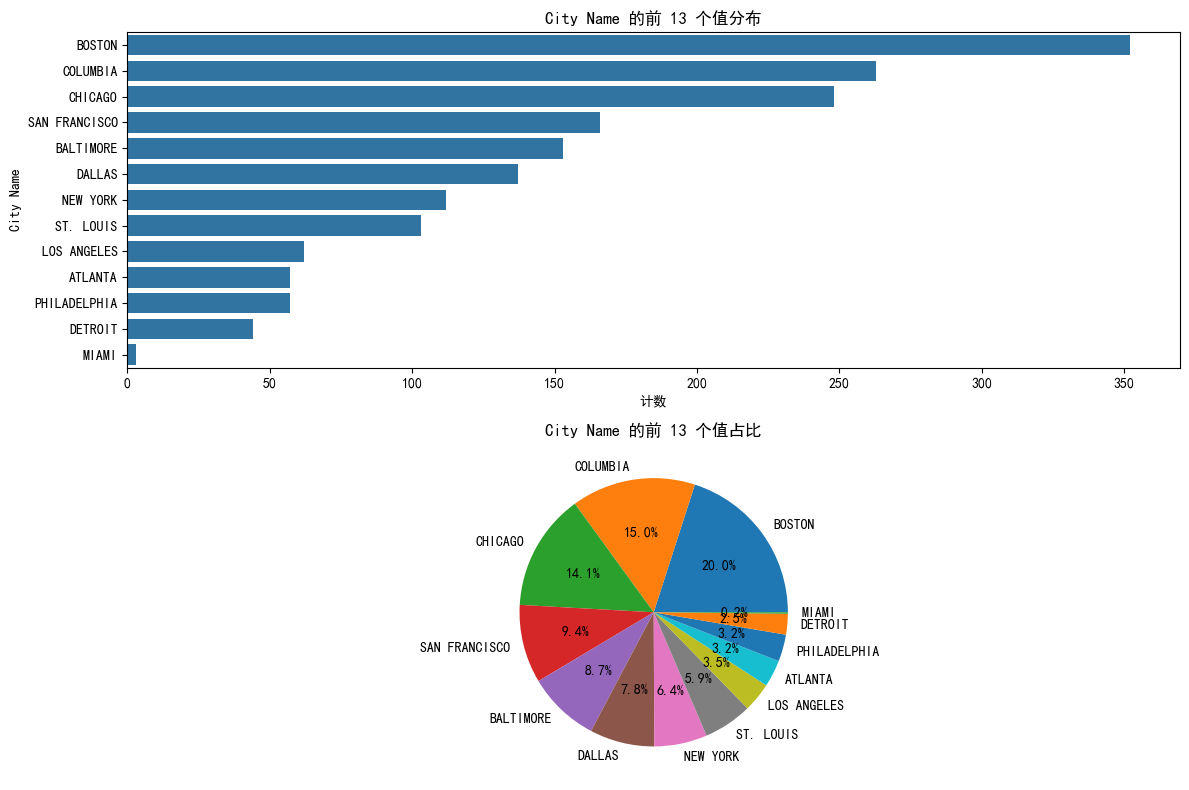

================================================== Type的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Type
Type的属性有1个
前1个频率值:
Type
Organic    45
Name: count, dtype: int64
前1个百分比:
Type
Organic    100.00%
Name: proportion, dtype: object


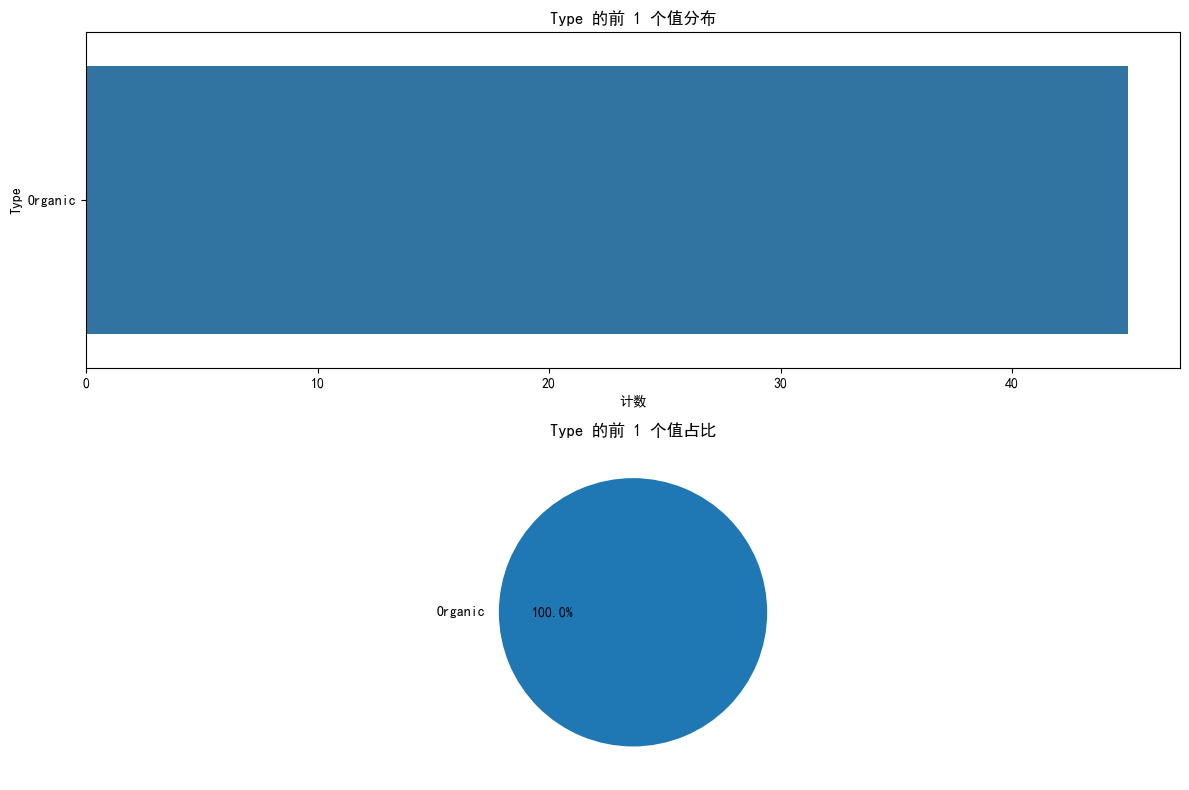

================================================== Package的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Package
Package的属性有15个
前15个频率值:
Package
36 inch bins            663
24 inch bins            551
1/2 bushel cartons      234
1 1/9 bushel cartons    117
35 lb cartons            42
bushel cartons           37
40 lb cartons            19
1 1/9 bushel crates      17
each                     17
bins                     13
50 lb sacks              11
50 lb cartons            10
bushel baskets           10
22 lb cartons            10
20 lb cartons             6
Name: count, dtype: int64
前15个百分比:
Package
36 inch bins            37.73%
24 inch bins            31.36%
1/2 bushel cartons      13.32%
1 1/9 bushel cartons     6.66%
35 lb cartons            2.39%
bushel cartons           2.11%
40 lb cartons            1.08%
1 1/9 bushel crates      0.97%
each                     0.97%
bins                     0.74%
50 lb sacks              0.63%
50 lb cartons          

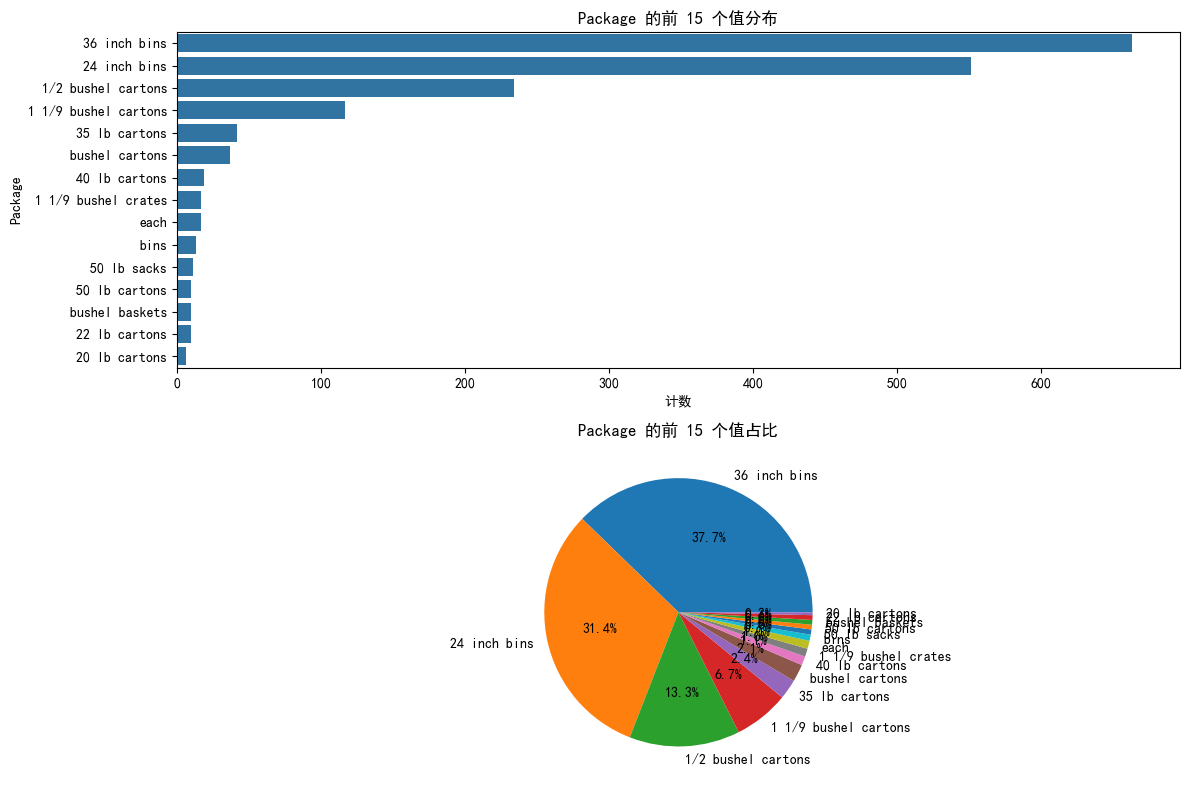

================================================== Variety的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Variety
Variety的属性有10个
前10个频率值:
Variety
HOWDEN TYPE                 542
PIE TYPE                    468
MINIATURE                   310
FAIRYTALE                   132
CINDERELLA                   81
BIG MACK TYPE                74
MIXED HEIRLOOM VARIETIES     57
HOWDEN WHITE TYPE            49
KNUCKLE HEAD                 20
BLUE TYPE                    19
Name: count, dtype: int64
前10个百分比:
Variety
HOWDEN TYPE                 30.94%
PIE TYPE                    26.71%
MINIATURE                   17.69%
FAIRYTALE                    7.53%
CINDERELLA                   4.62%
BIG MACK TYPE                4.22%
MIXED HEIRLOOM VARIETIES     3.25%
HOWDEN WHITE TYPE            2.80%
KNUCKLE HEAD                 1.14%
BLUE TYPE                    1.08%
Name: proportion, dtype: object


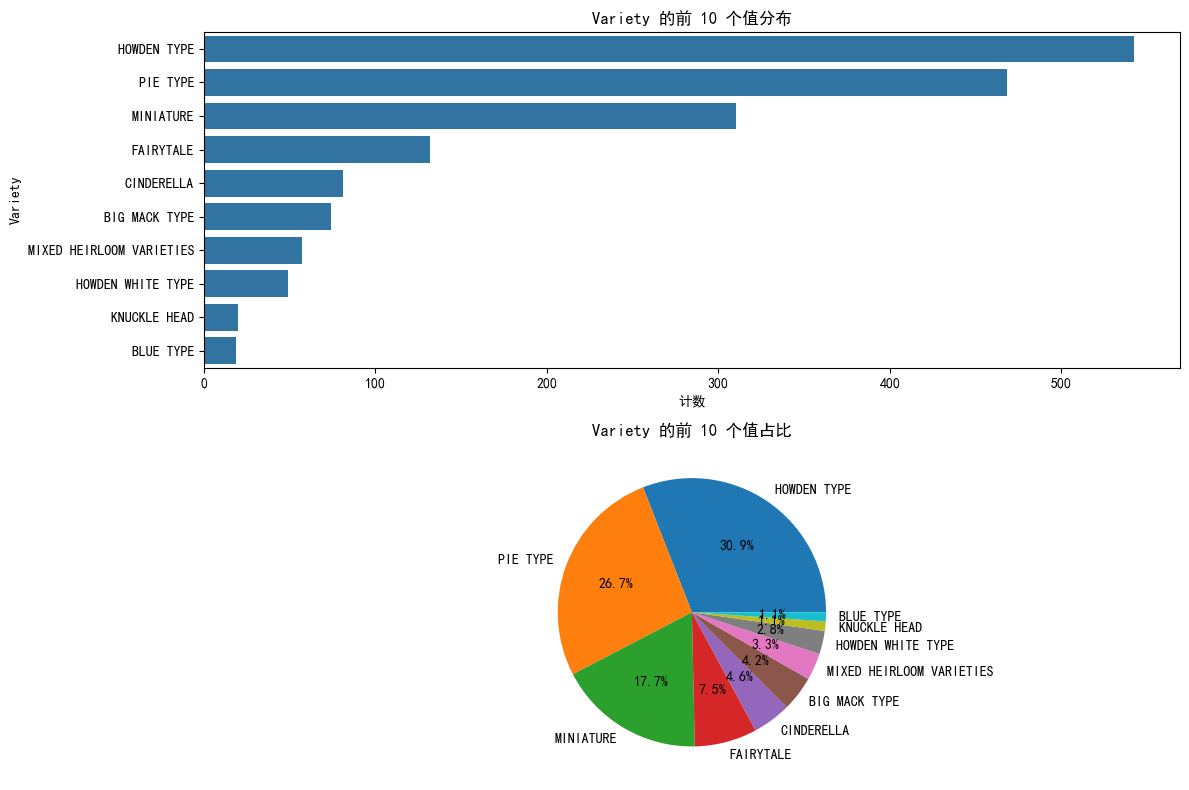

================================================== Sub Variety的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Sub Variety
Sub Variety的属性有2个
前2个频率值:
Sub Variety
FLAT TYPE     212
ROUND TYPE     84
Name: count, dtype: int64
前2个百分比:
Sub Variety
FLAT TYPE     71.62%
ROUND TYPE    28.38%
Name: proportion, dtype: object


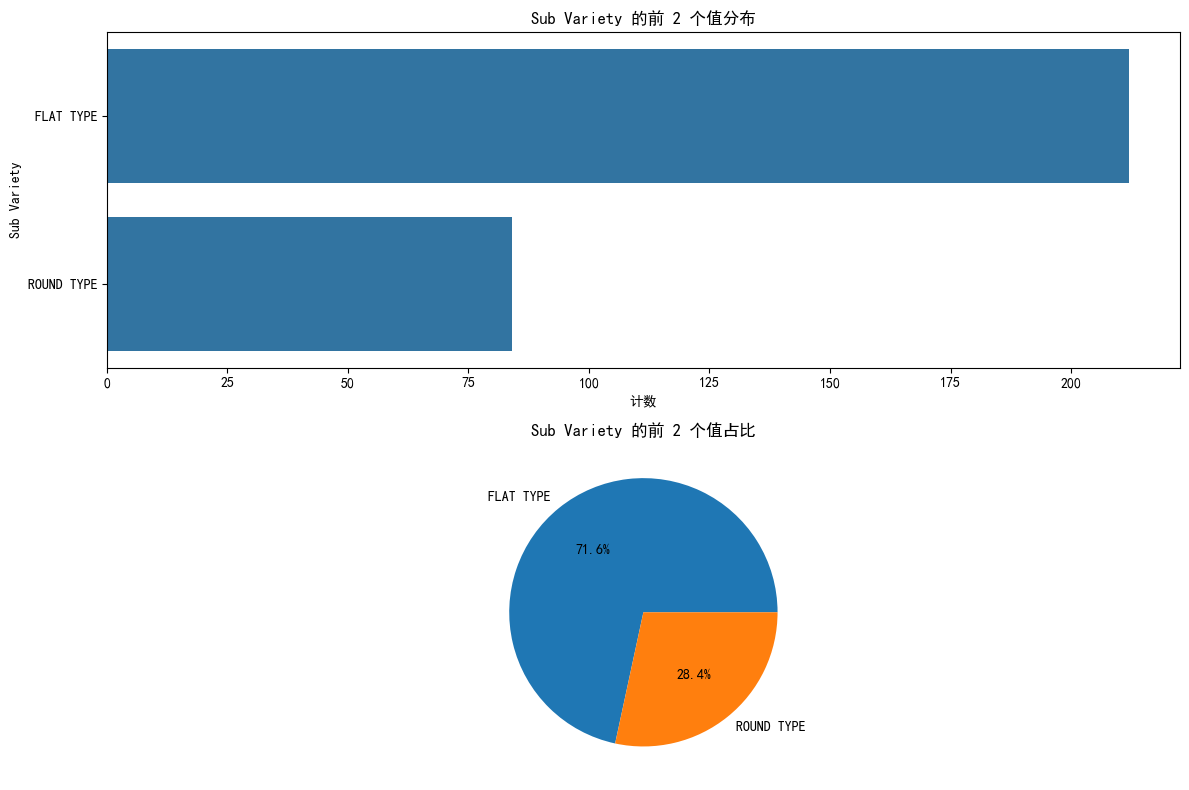

================================================== Grade的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Grade' 中数据为空!⚠⚠⚠⚠
================================================== Date的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Date
Date的属性有57个
⚠⚠注意该特征属性太多，只绘制前 15 个！！！
前15个频率值:
Date
10/8/16     180
10/15/16    177
10/22/16    175
10/29/16    173
10/1/16     163
9/24/16     142
9/30/17     132
9/23/17     121
11/5/16      97
9/16/17      92
11/12/16     36
9/9/17       29
11/19/16     27
9/29/16      22
9/30/16      21
Name: count, dtype: int64
前15个百分比:
Date
10/8/16     10.24%
10/15/16    10.07%
10/22/16     9.96%
10/29/16     9.85%
10/1/16      9.28%
9/24/16      8.08%
9/30/17      7.51%
9/23/17      6.89%
11/5/16      5.52%
9/16/17      5.24%
11/12/16     2.05%
9/9/17       1.65%
11/19/16     1.54%
9/29/16      1.25%
9/30/16      1.20%
Name: proportion, dtype: object


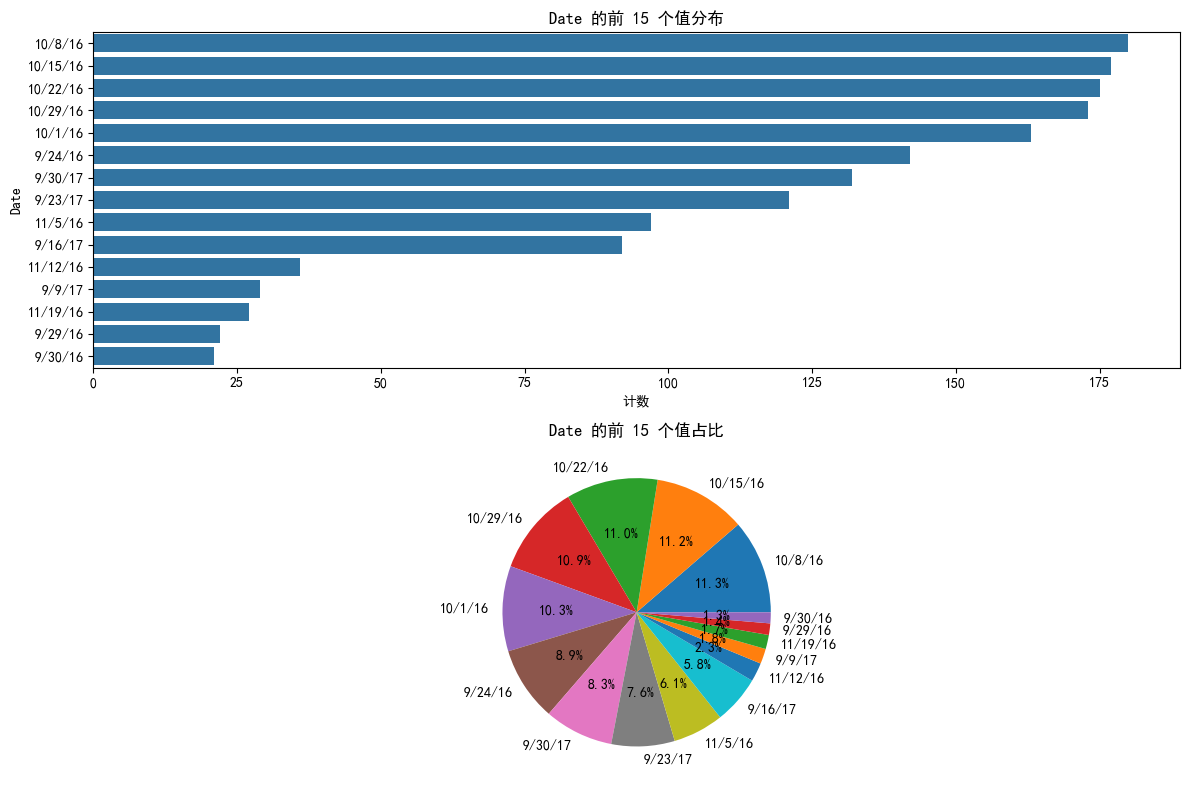

================================================== Low Price的自动探索性数据分析 ==================================================
检测到数值型数据: Low Price
基本统计量:
count    1757.000000
mean      124.571338
std        83.876591
min         0.240000
25%        24.000000
50%       140.000000
75%       180.000000
max       480.000000
Name: Low Price, dtype: float64


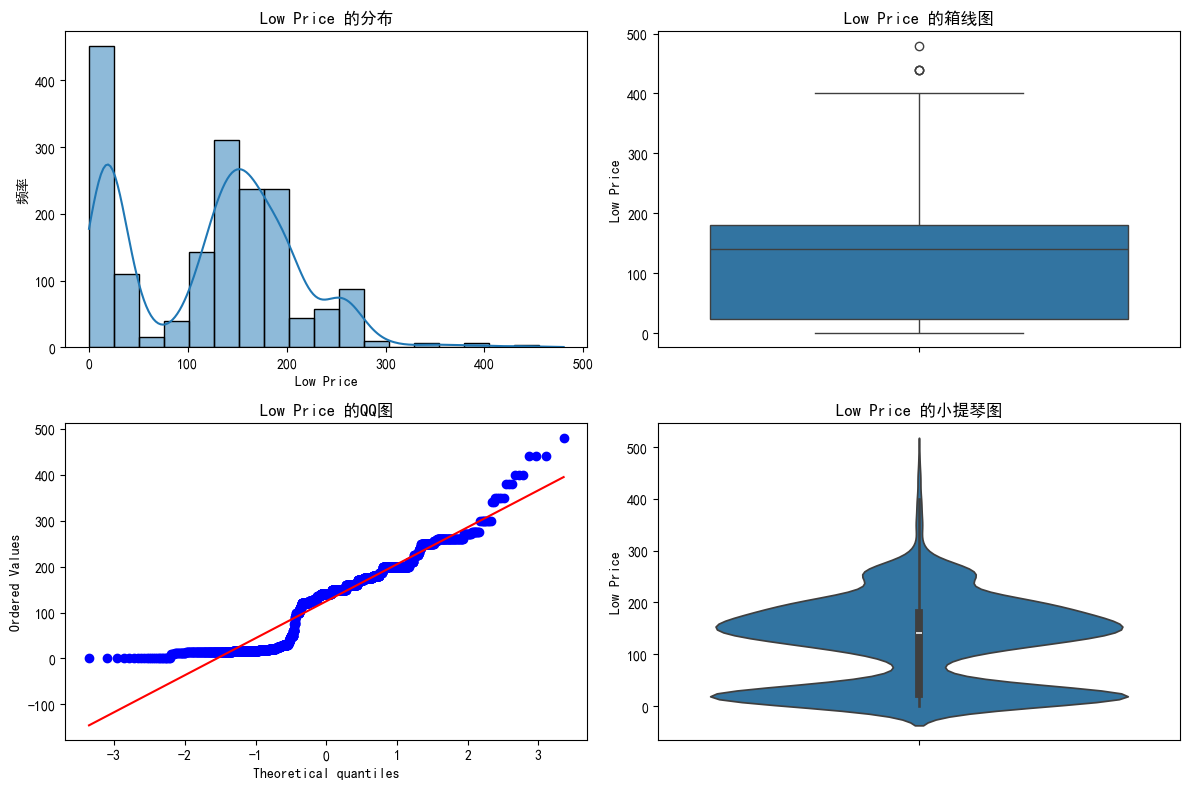

================================================== High Price的自动探索性数据分析 ==================================================
检测到数值型数据: High Price
基本统计量:
count    1757.000000
mean      132.970939
std        89.524958
min         0.240000
25%        24.500000
50%       150.000000
75%       200.000000
max       480.000000
Name: High Price, dtype: float64


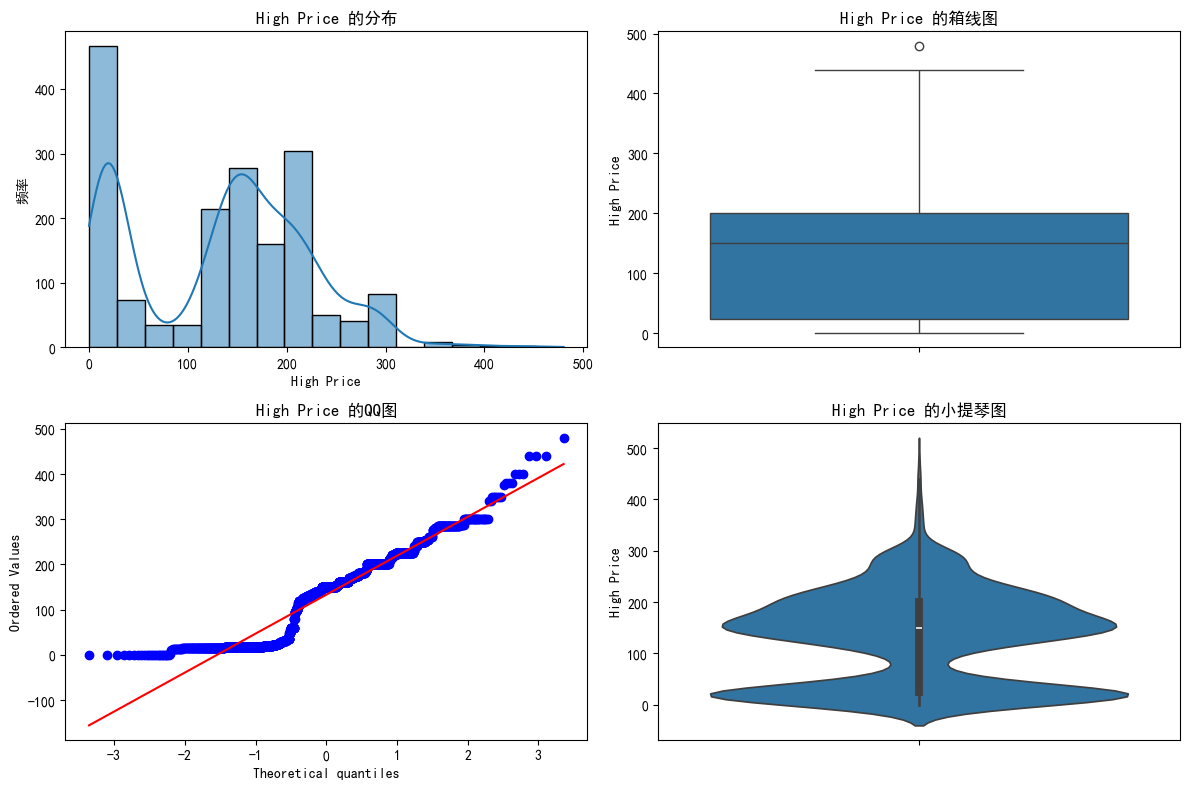

================================================== Mostly Low的自动探索性数据分析 ==================================================
检测到数值型数据: Mostly Low
基本统计量:
count    1654.000000
mean      128.170550
std        86.512161
min         0.240000
25%        24.625000
50%       147.000000
75%       185.000000
max       480.000000
Name: Mostly Low, dtype: float64


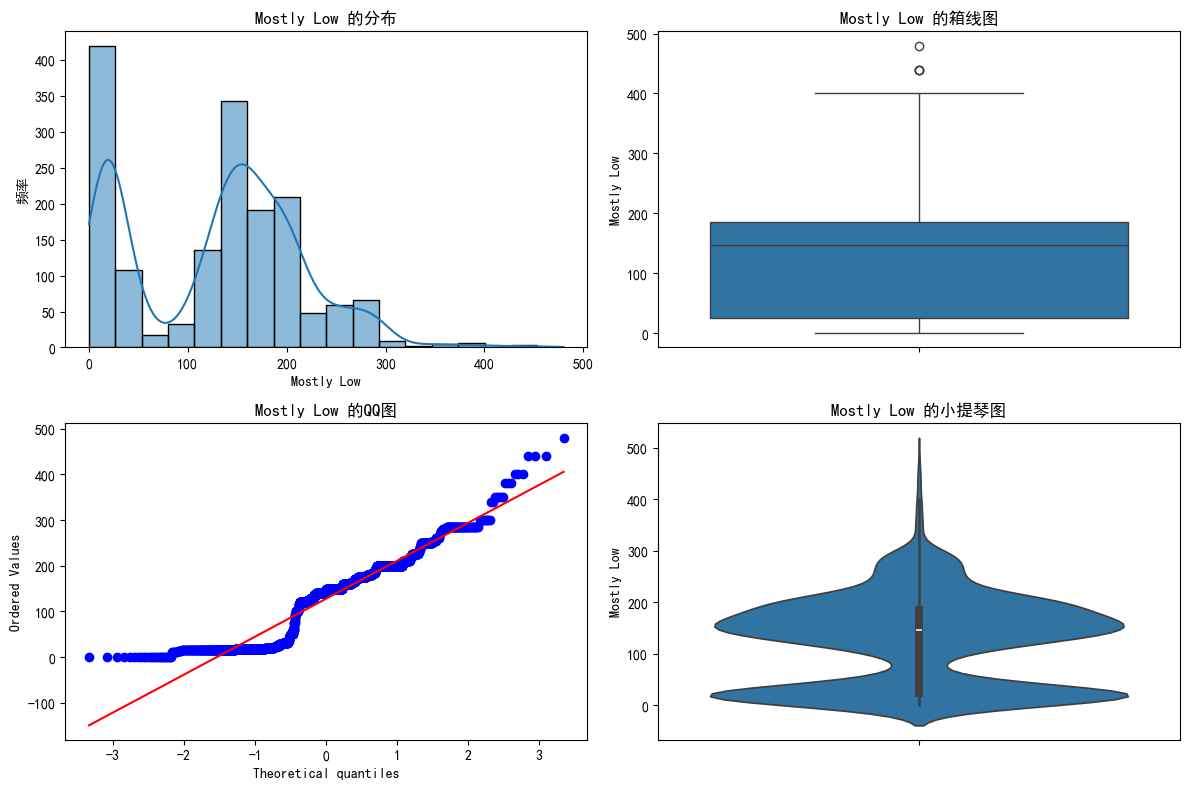

================================================== Mostly High的自动探索性数据分析 ==================================================
检测到数值型数据: Mostly High
基本统计量:
count    1654.000000
mean      132.491802
std        88.442967
min         0.240000
25%        26.125000
50%       150.000000
75%       200.000000
max       480.000000
Name: Mostly High, dtype: float64


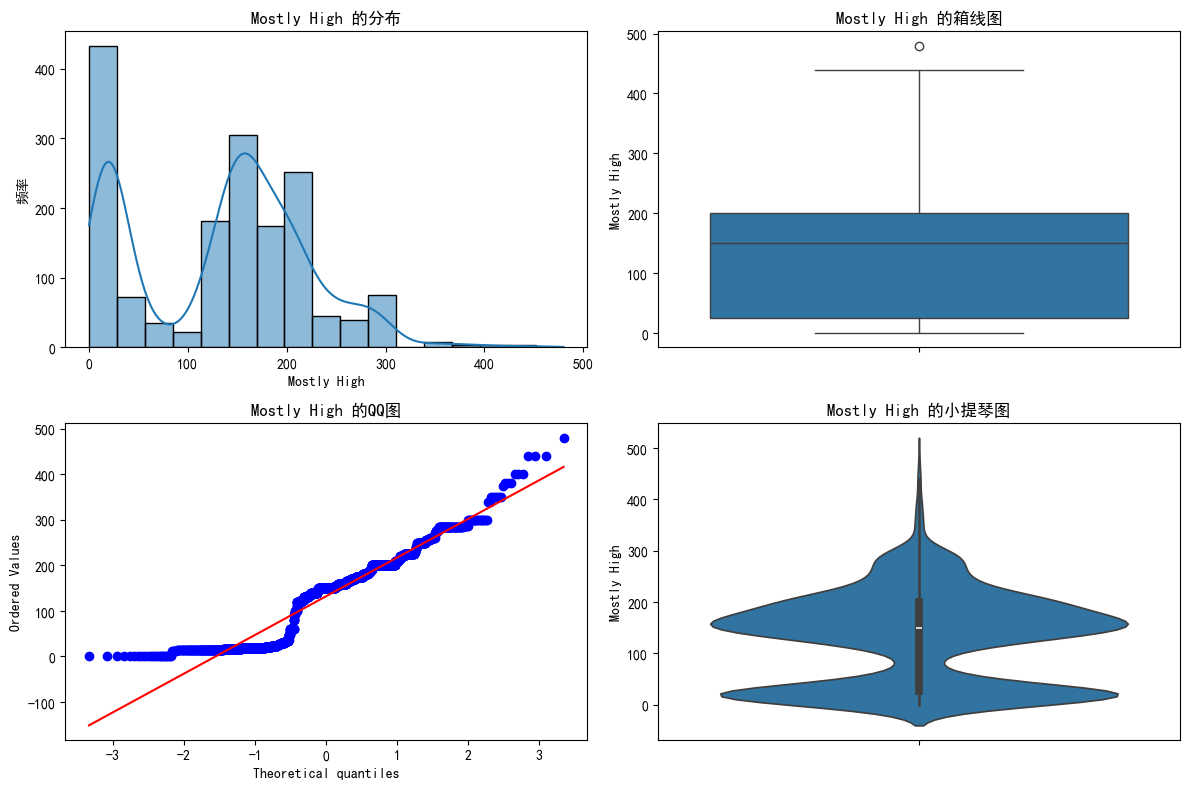

================================================== Origin的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Origin
Origin的属性有24个
⚠⚠注意该特征属性太多，只绘制前 15 个！！！
前15个频率值:
Origin
PENNSYLVANIA      250
MICHIGAN          237
CALIFORNIA        218
MASSACHUSETTS     197
ILLINOIS          156
TEXAS             115
OHIO              111
CANADA             86
MARYLAND           83
NORTH CAROLINA     67
VIRGINIA           65
MEXICO             45
NEW JERSEY         33
NEW YORK           26
DELAWARE           18
Name: count, dtype: int64
前15个百分比:
Origin
PENNSYLVANIA      14.25%
MICHIGAN          13.51%
CALIFORNIA        12.43%
MASSACHUSETTS     11.23%
ILLINOIS           8.89%
TEXAS              6.56%
OHIO               6.33%
CANADA             4.90%
MARYLAND           4.73%
NORTH CAROLINA     3.82%
VIRGINIA           3.71%
MEXICO             2.57%
NEW JERSEY         1.88%
NEW YORK           1.48%
DELAWARE           1.03%
Name: proportion, dtype: object


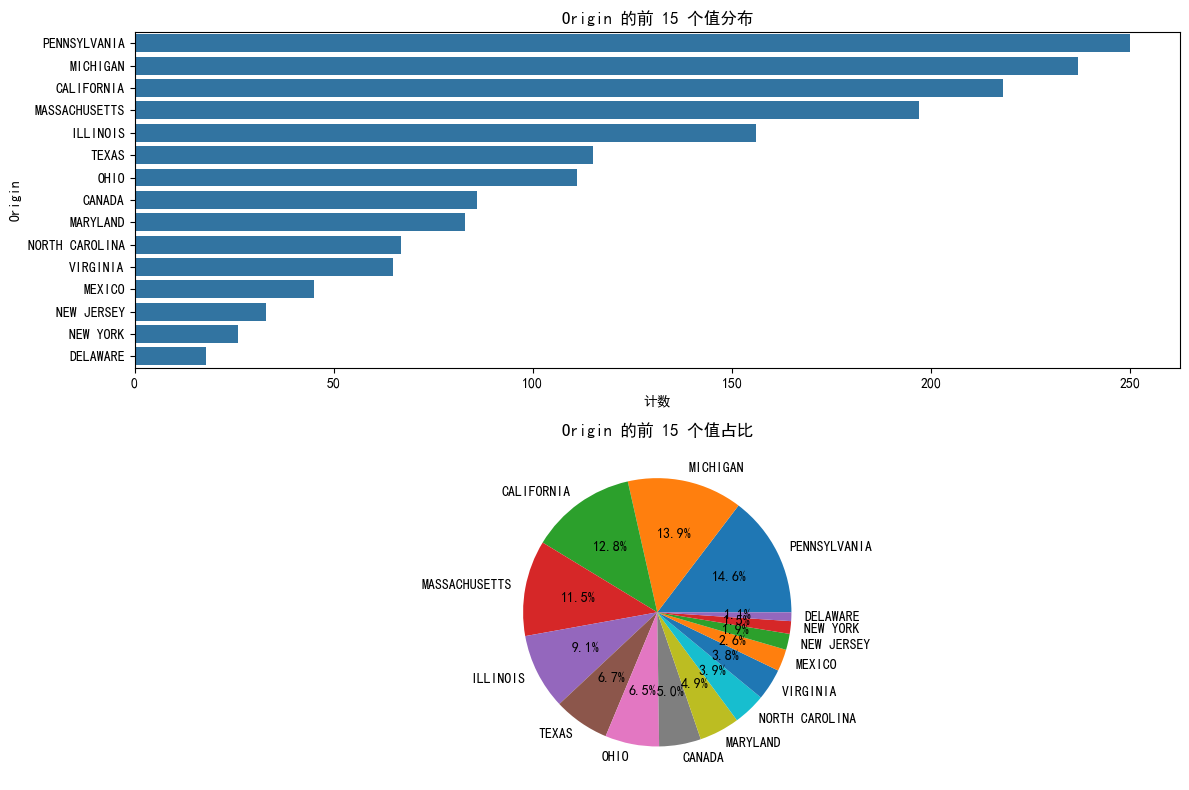

================================================== Origin District的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Origin District
Origin District的属性有5个
前5个频率值:
Origin District
QUEBEC                                   48
ONTARIO                                  37
CENTRAL SAN JOAQUIN VALLEY CALIFORNIA    31
WESTERN SECTION                           9
ORANGE COUNTY NEW YORK                    6
Name: count, dtype: int64
前5个百分比:
Origin District
QUEBEC                                   36.64%
ONTARIO                                  28.24%
CENTRAL SAN JOAQUIN VALLEY CALIFORNIA    23.66%
WESTERN SECTION                           6.87%
ORANGE COUNTY NEW YORK                    4.58%
Name: proportion, dtype: object


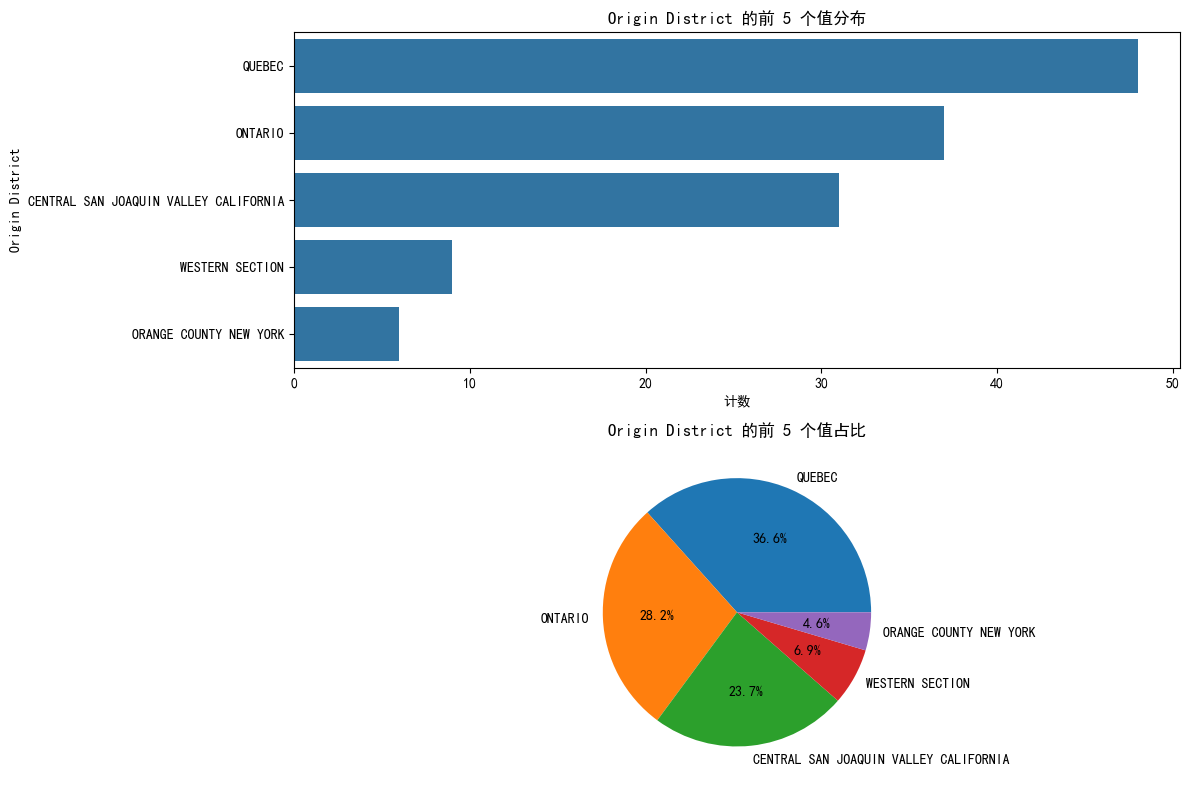

================================================== Item Size的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Item Size
Item Size的属性有7个
前7个频率值:
Item Size
sml        363
med        337
lge        295
xlge       205
med-lge    133
jbo        128
exjbo       17
Name: count, dtype: int64
前7个百分比:
Item Size
sml        24.56%
med        22.80%
lge        19.96%
xlge       13.87%
med-lge     9.00%
jbo         8.66%
exjbo       1.15%
Name: proportion, dtype: object


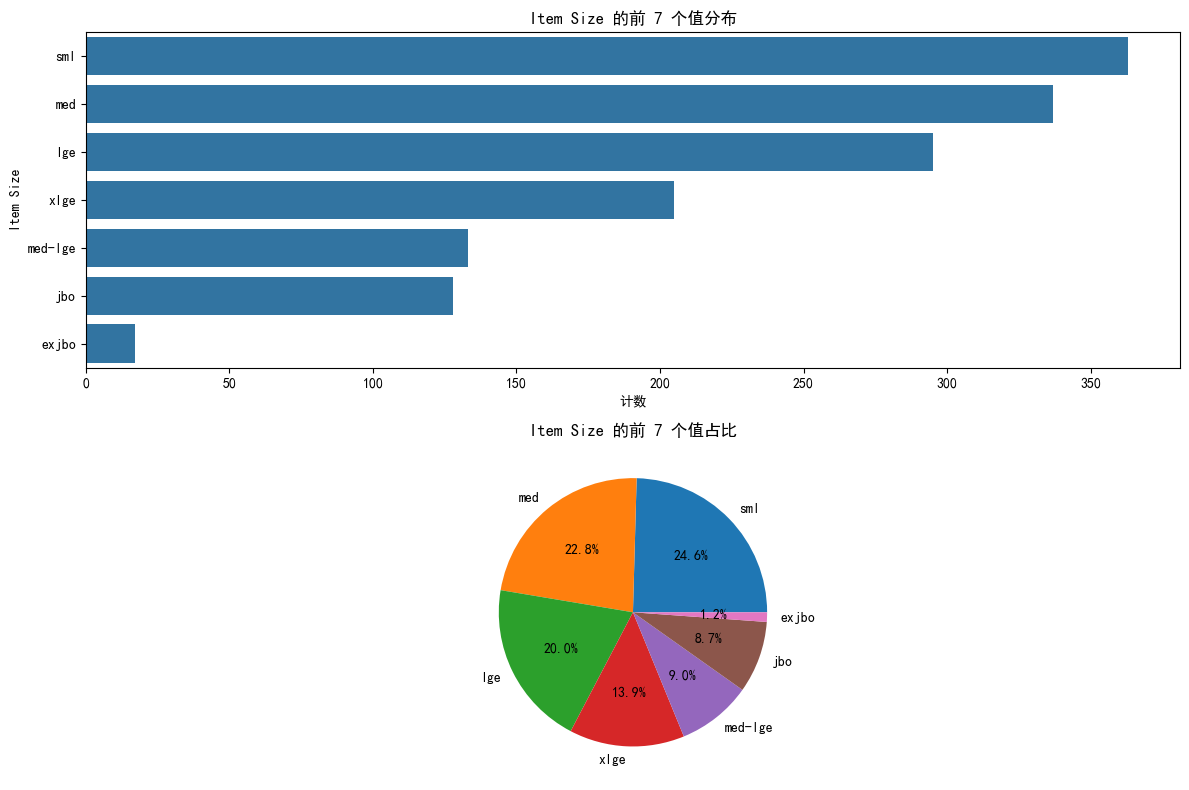

================================================== Color的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Color
Color的属性有3个
前3个频率值:
Color
ORANGE     916
WHITE      213
STRIPED     12
Name: count, dtype: int64
前3个百分比:
Color
ORANGE     80.28%
WHITE      18.67%
STRIPED     1.05%
Name: proportion, dtype: object


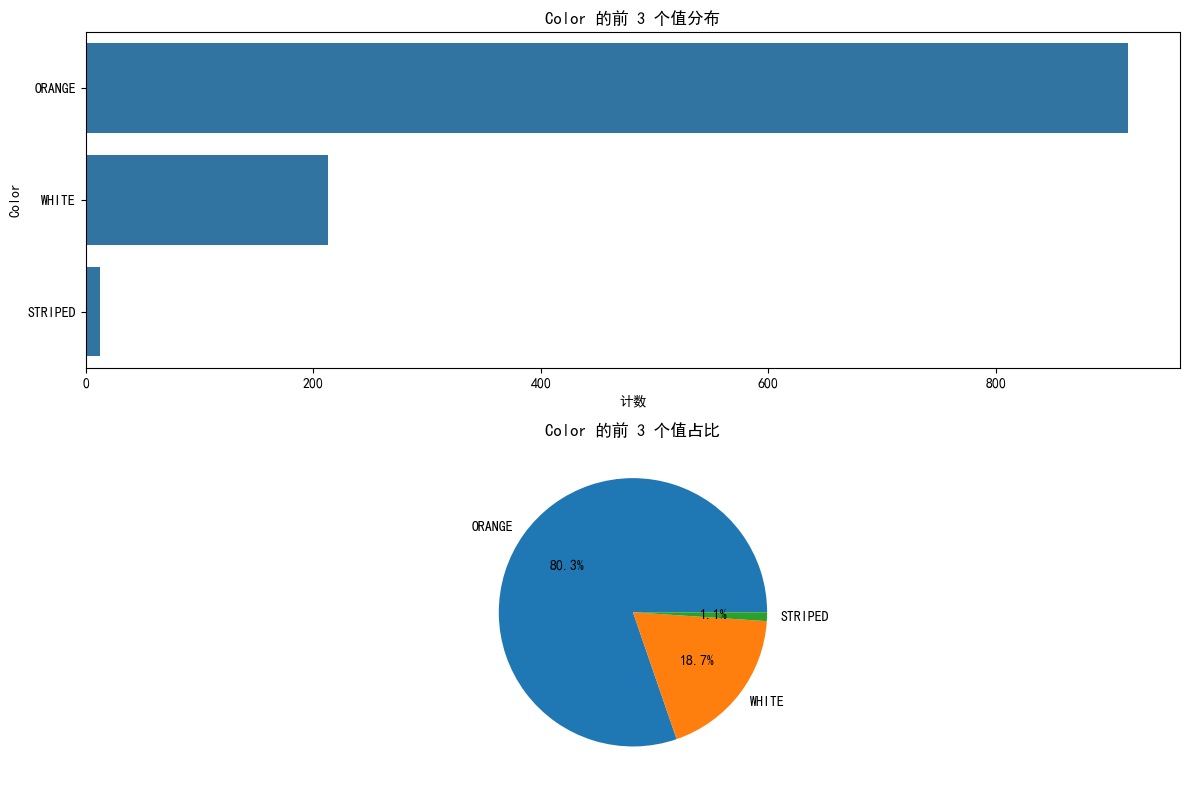

================================================== Environment的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Environment' 中数据为空!⚠⚠⚠⚠
================================================== Unit of Sale的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Unit of Sale
Unit of Sale的属性有4个
前4个频率值:
Unit of Sale
PER BIN       98
EACH          29
PER LB        24
SHELLACKED    11
Name: count, dtype: int64
前4个百分比:
Unit of Sale
PER BIN       60.49%
EACH          17.90%
PER LB        14.81%
SHELLACKED     6.79%
Name: proportion, dtype: object


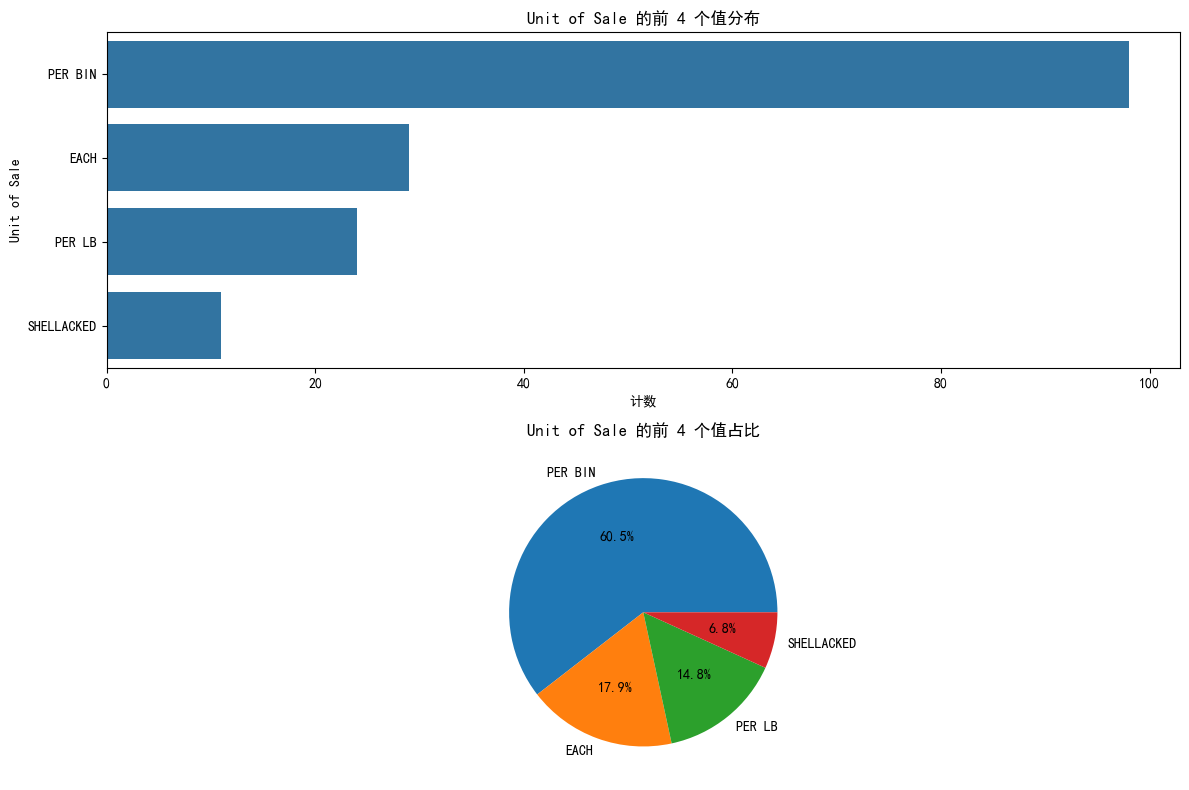

================================================== Quality的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Quality' 中数据为空!⚠⚠⚠⚠
================================================== Condition的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Condition' 中数据为空!⚠⚠⚠⚠
================================================== Appearance的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Appearance' 中数据为空!⚠⚠⚠⚠
================================================== Storage的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Storage' 中数据为空!⚠⚠⚠⚠
================================================== Crop的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Crop' 中数据为空!⚠⚠⚠⚠
================================================== Repack的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Repack
Repack的属性有2个
前2个频率值:
Repack
N    1752
E       5
Name: count, dtype: int64
前2个百分比:
Repack
N    99.72%
E     0.28%
Name

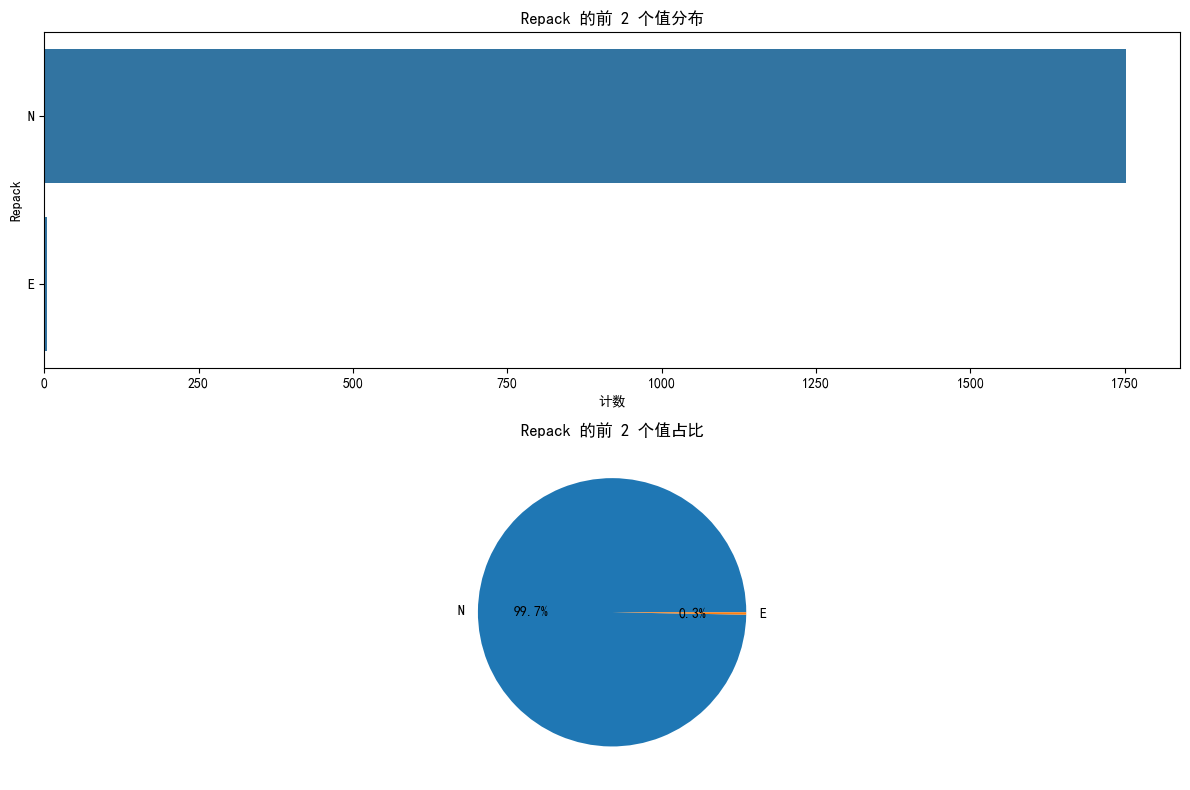

================================================== Trans Mode的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Trans Mode' 中数据为空!⚠⚠⚠⚠
================================================== Unnamed: 24的自动探索性数据分析 ==================================================
⚠⚠⚠⚠列名 'Unnamed: 24' 中数据为空!⚠⚠⚠⚠
================================================== Unnamed: 25的自动探索性数据分析 ==================================================
检测到分类/字符串数据: Unnamed: 25
Unnamed: 25的属性有4个
前4个频率值:
Unnamed: 25
LOWER.                             41
MINIATURE LOWER, OTHERS STEADY.    22
STEADY.                            20
ABOUT STEADY.                      20
Name: count, dtype: int64
前4个百分比:
Unnamed: 25
LOWER.                             39.81%
MINIATURE LOWER, OTHERS STEADY.    21.36%
STEADY.                            19.42%
ABOUT STEADY.                      19.42%
Name: proportion, dtype: object


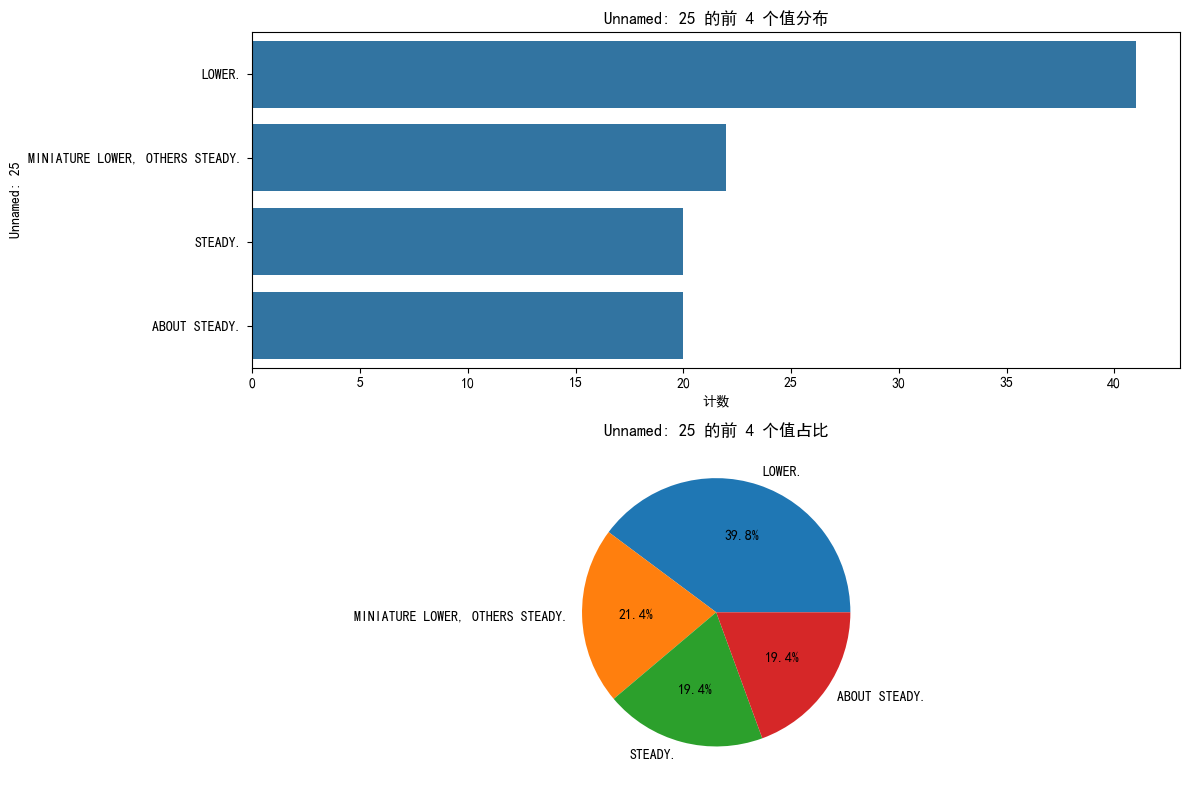

In [45]:
# 假设df是你的数据框
import pandas as pd
data =pd.read_csv(r'../data/US-pumpkins.csv')
for i in data.columns:
    auto_eda(data,i)

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

def data_y_xi_show(data, x, y):
    """
    y为数值类型，x为数值类型或分类类型或者日期时间类型
    此函数通过自动检测数据类型，并通过散点图+均值折线可视化展示x与y之间的关系
    
    参数:
    data: pandas DataFrame 数据框
    x: 字符串，自变量列名
    y: 字符串，因变量列名（必须是数值类型）
    
    注：当x为数值或者日期时间类型时，此函数会自动根据x大小排序绘制折线；
        当x为分类类型时，此函数会自动根据x的y均值排序绘制折线
    """
    # 检查列是否存在
    if x not in data.columns:
        raise ValueError(f"列 '{x}' 不在数据框中")
    if y not in data.columns:
        raise ValueError(f"列 '{y}' 不在数据框中")
    
    # 检查y是否为数值型
    if not pd.api.types.is_numeric_dtype(data[y]):
        raise TypeError(f"y列 '{y}' 必须是数值类型")
    
    if x not in data.columns:
        print(f"列名 '{x}' 不在数据集中")
    
    if data[x] is None or data[x].isnull().all():
        print(f"⚠⚠⚠⚠列名 '{x}' 中数据为空!⚠⚠⚠⚠")
        return None
    
    # 创建一个副本避免修改原始数据
    df = data.copy()
    
    # 创建图形
    plt.figure(figsize=(12, 8))
    
    # 判断x的数据类型
    if pd.api.types.is_numeric_dtype(df[x]):
        # 数值型x
        print(f"检测到数值型x: {x}")
        
        # 排序数据，以便正确绘制折线图
        sorted_df = df.sort_values(by=x)
        
        # 数值分箱处理
        n_bins = min(20, len(df[x].unique()))  # 限制最大分箱数
        
        # 创建分箱
        bins = np.linspace(df[x].min(), df[x].max(), n_bins + 1)
        bin_labels = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
        df['bin'] = pd.cut(df[x], bins=bins, labels=bin_labels)
        
        # 计算每个分箱的均值
        bin_avg = df.groupby('bin')[y].mean().reset_index()
        
        # 散点图展示原始数据
        plt.scatter(df[x], df[y], alpha=0.5, label='原始数据点')
        
        # 绘制均值折线
        plt.plot(bin_avg['bin'], bin_avg[y], 'r-o', linewidth=2, label=f'{x}分组平均{y}')
        
        # 绘制全局均值线
        plt.axhline(y=df[y].mean(), color='g', linestyle='--', label=f'全局平均{y}')
        
        plt.title(f'{x}与{y}的关系', fontsize=14)
        plt.xlabel(x, fontsize=12)
        plt.ylabel(y, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        
    elif pd.api.types.is_datetime64_dtype(df[x]) or isinstance(df[x].iloc[0], (datetime, pd.Timestamp)):
        # 日期时间型x
        print(f"检测到日期时间型x: {x}")
        
        # 确保x是日期时间类型
        if not pd.api.types.is_datetime64_dtype(df[x]):
            df[x] = pd.to_datetime(df[x])
        
        # 排序数据，以便正确绘制折线图
        sorted_df = df.sort_values(by=x)
        
        # 计算每天的均值
        daily_avg = df.groupby(x)[y].mean().reset_index()
        
        # 散点图展示原始数据
        plt.scatter(df[x], df[y], alpha=0.5, label='原始数据点')
        
        # 绘制均值折线
        plt.plot(daily_avg[x], daily_avg[y], 'r-o', linewidth=2, label=f'日期平均{y}')
        
        # 绘制全局均值线
        plt.axhline(y=df[y].mean(), color='g', linestyle='--', label=f'全局平均{y}')
        
        plt.title(f'{x}与{y}的关系', fontsize=14)
        plt.xlabel(x, fontsize=12)
        plt.ylabel(y, fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='best')
        
    else:
        # 分类型x
        print(f"检测到分类型x: {x}")
        
        # 限制类别数量
        max_categories = 15
        top_categories = df[x].value_counts().nlargest(max_categories).index.tolist()
        
        filtered_df = df
        
        # 计算每个类别的y均值并按均值降序排序
        cat_avg = filtered_df.groupby(x)[y].mean().sort_values(ascending=False)
        cat_order = cat_avg.index
        
        # 创建映射字典，用于对原始数据中的类别进行排序
        cat_map = {cat: i for i, cat in enumerate(cat_order)}
        
        # 获取排序后的位置
        cat_positions = [cat_map.get(c, -1) for c in filtered_df[x]]
        
        # 散点图展示原始数据（按均值排序后的位置）
        plt.scatter(cat_positions, filtered_df[y], alpha=0.5, label='原始数据点')
        
        # 绘制均值折线
        positions = np.arange(len(cat_avg))
        plt.plot(positions, cat_avg.values, 'r-o', linewidth=2, label=f'{x}类别平均{y}')
        
        # 绘制全局均值线
        plt.axhline(y=df[y].mean(), color='g', linestyle='--', label=f'全局平均{y}')
        
        plt.title(f'{x}与{y}的关系（按{y}降序排序' + 
                 (f'，仅显示前{max_categories}种）' if len(df[x].unique()) > max_categories else '）'), 
                 fontsize=14)
        plt.xlabel(x, fontsize=12)
        plt.ylabel(y, fontsize=12)
        plt.xticks(range(len(cat_order)), cat_order, rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend(loc='upper right')
    
    # 适应图形布局
    plt.tight_layout()
    
    # 显示图形
    plt.show()
    
    # 返回一些统计信息
    result = {
        "相关系数": df[[x, y]].corr().iloc[0, 1] if pd.api.types.is_numeric_dtype(df[x]) else None,
        f"{y}均值": df[y].mean(),
        f"{y}中位数": df[y].median(),
        f"{y}标准差": df[y].std(),
        f"{y}最小值": df[y].min(),
        f"{y}最大值": df[y].max()
    }
    
    # 如果x是分类型，返回每个类别的y均值（降序排列）
    if not (pd.api.types.is_numeric_dtype(df[x]) or pd.api.types.is_datetime64_dtype(df[x])):
        result[f"按{y}降序排列的{x}均值"] = df.groupby(x)[y].mean().sort_values(ascending=False).to_dict()
    
    return result


检测到分类型x: City Name


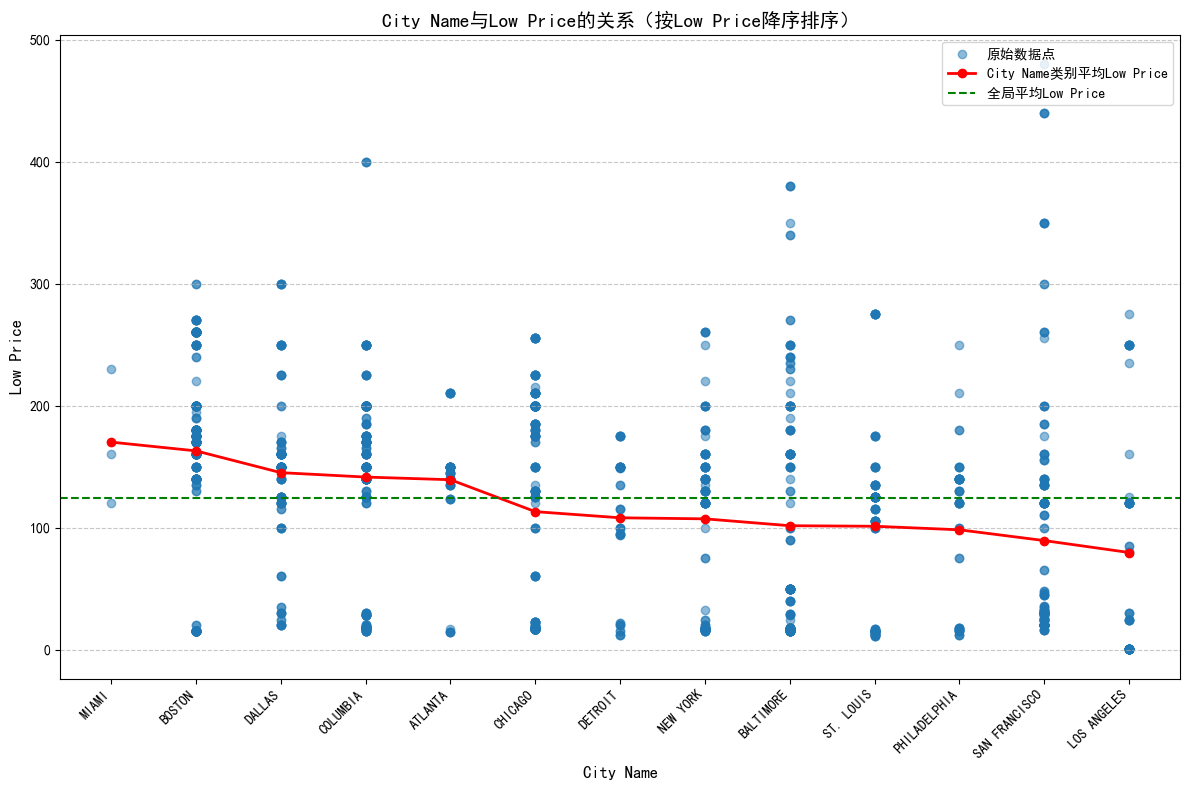

检测到分类型x: Type


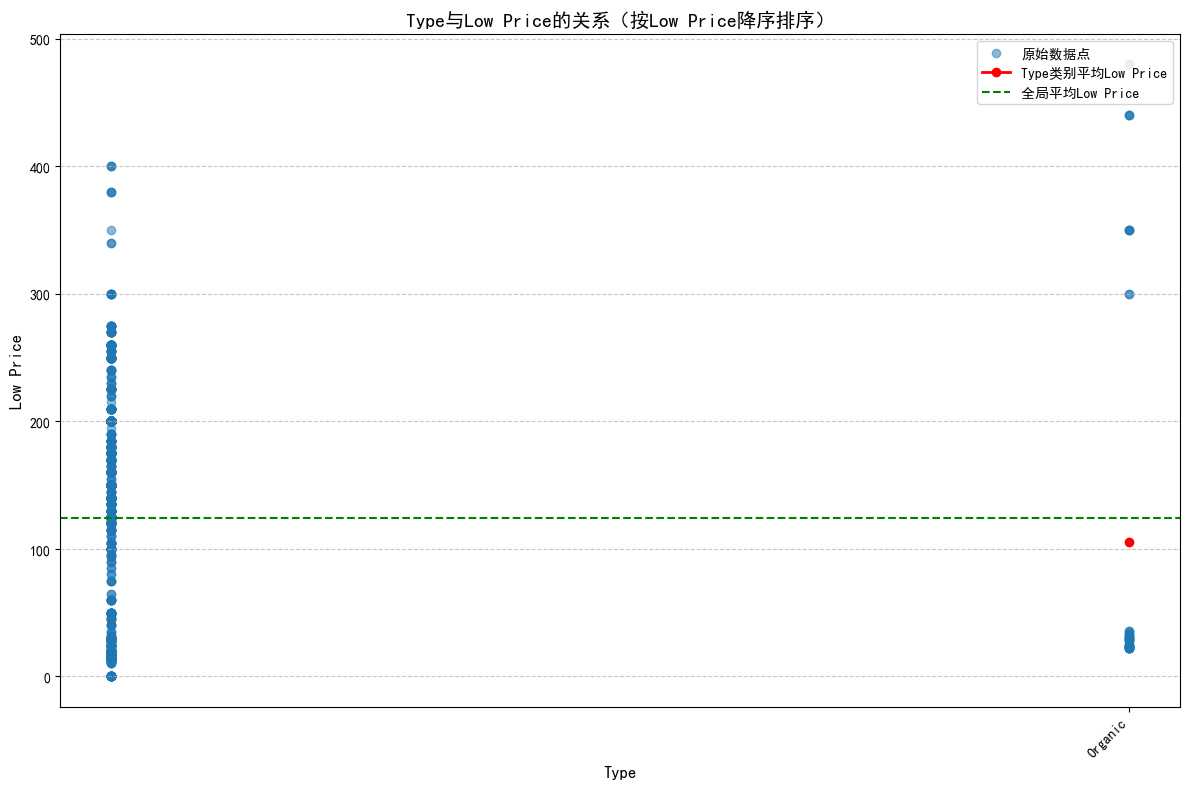

检测到分类型x: Package


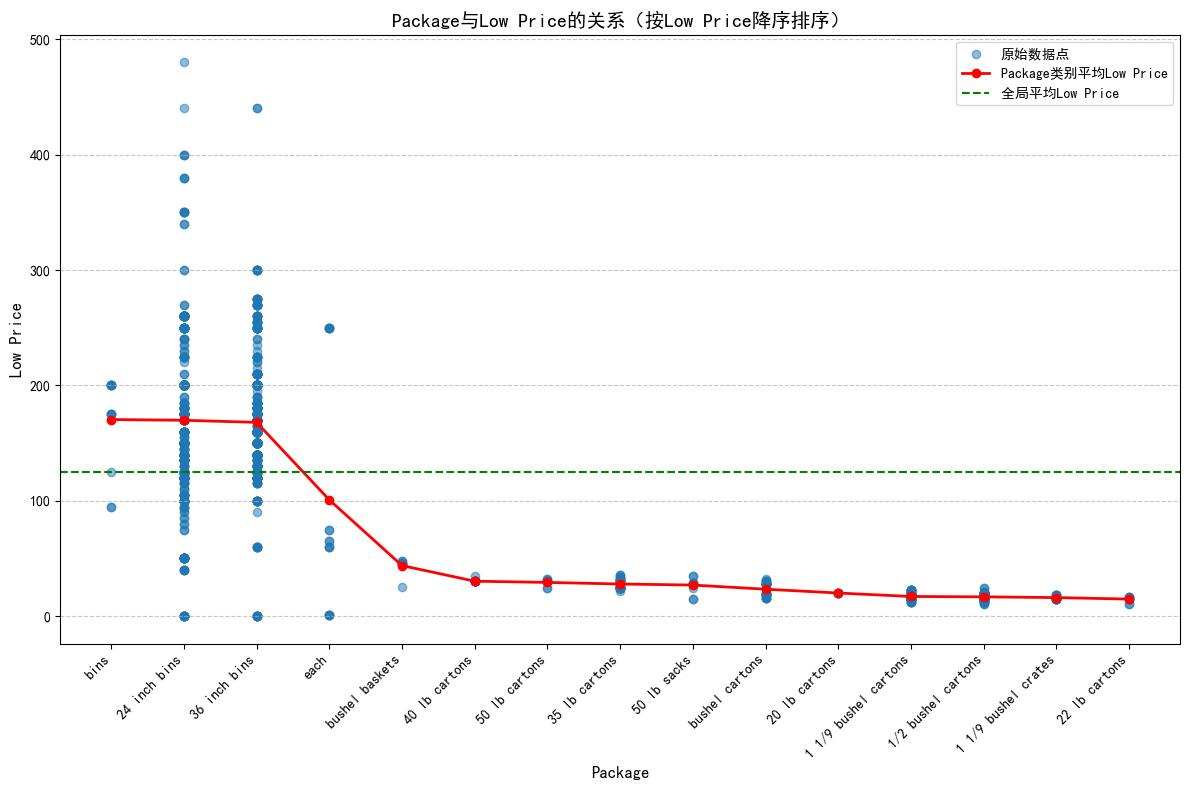

检测到分类型x: Variety


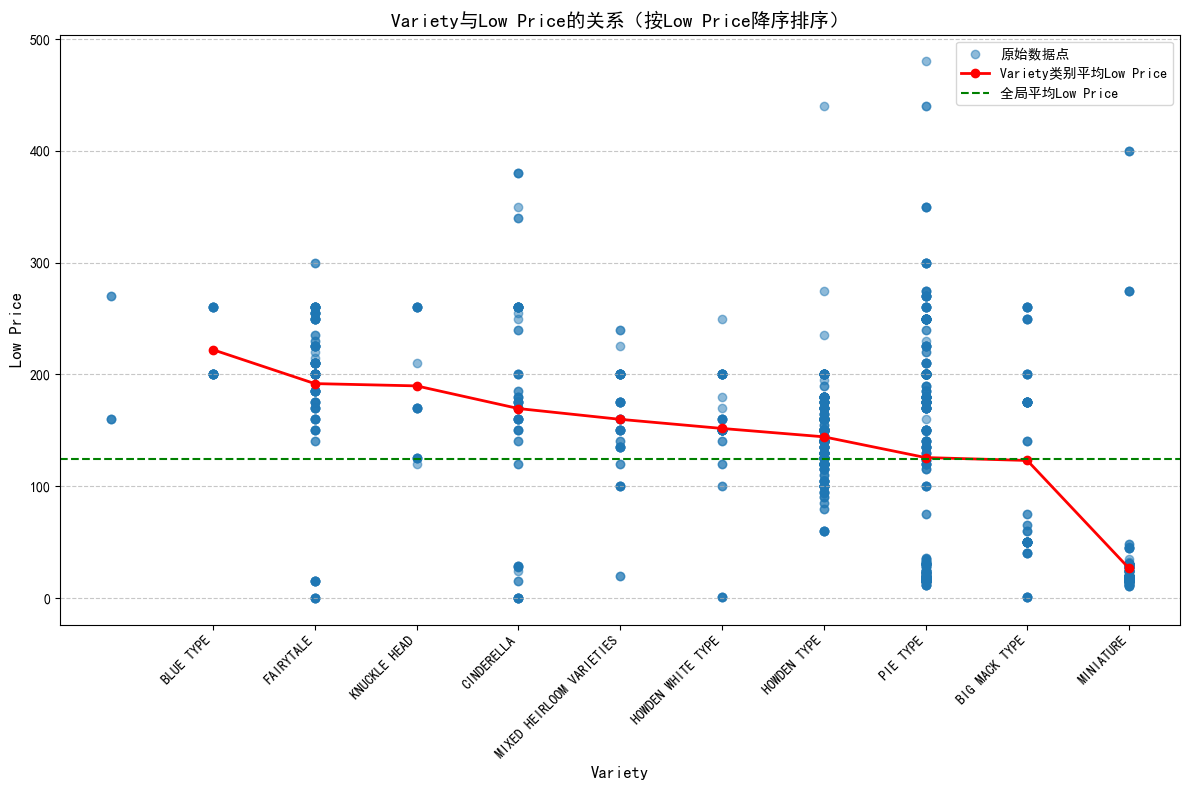

检测到分类型x: Sub Variety


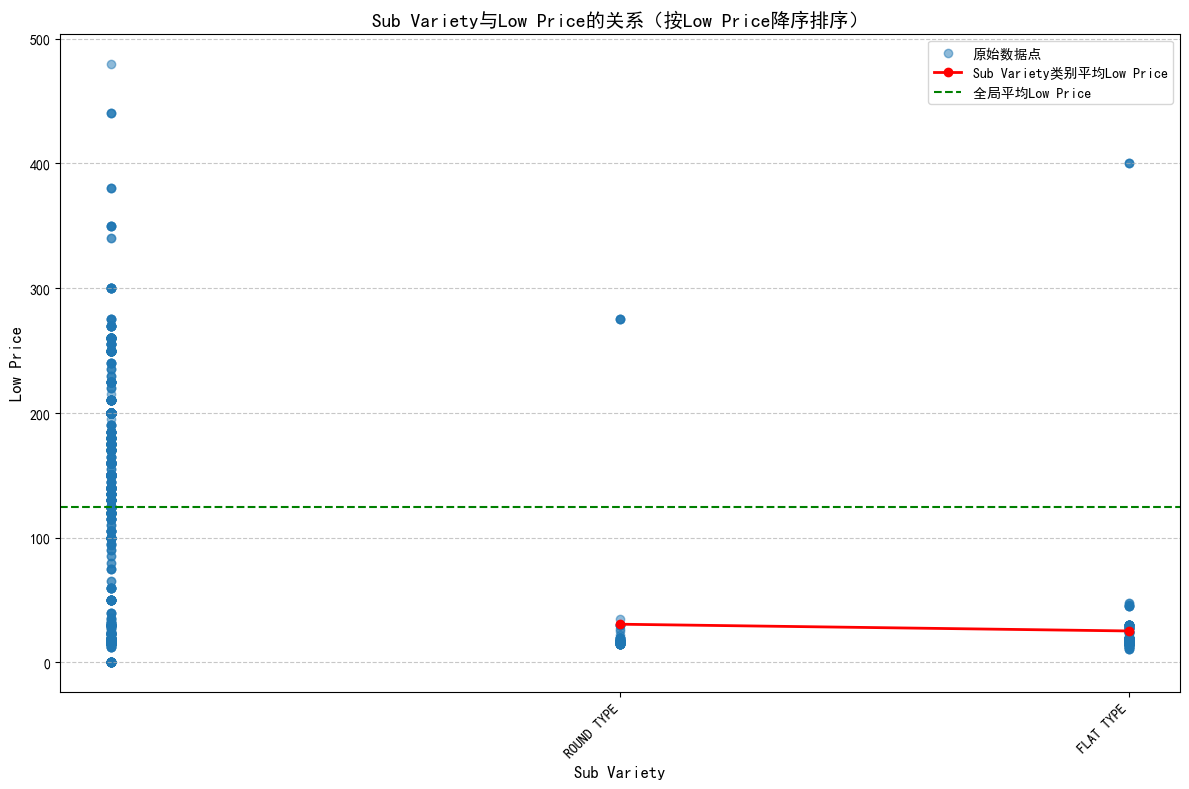

⚠⚠⚠⚠列名 'Grade' 中数据为空!⚠⚠⚠⚠
检测到分类型x: Date


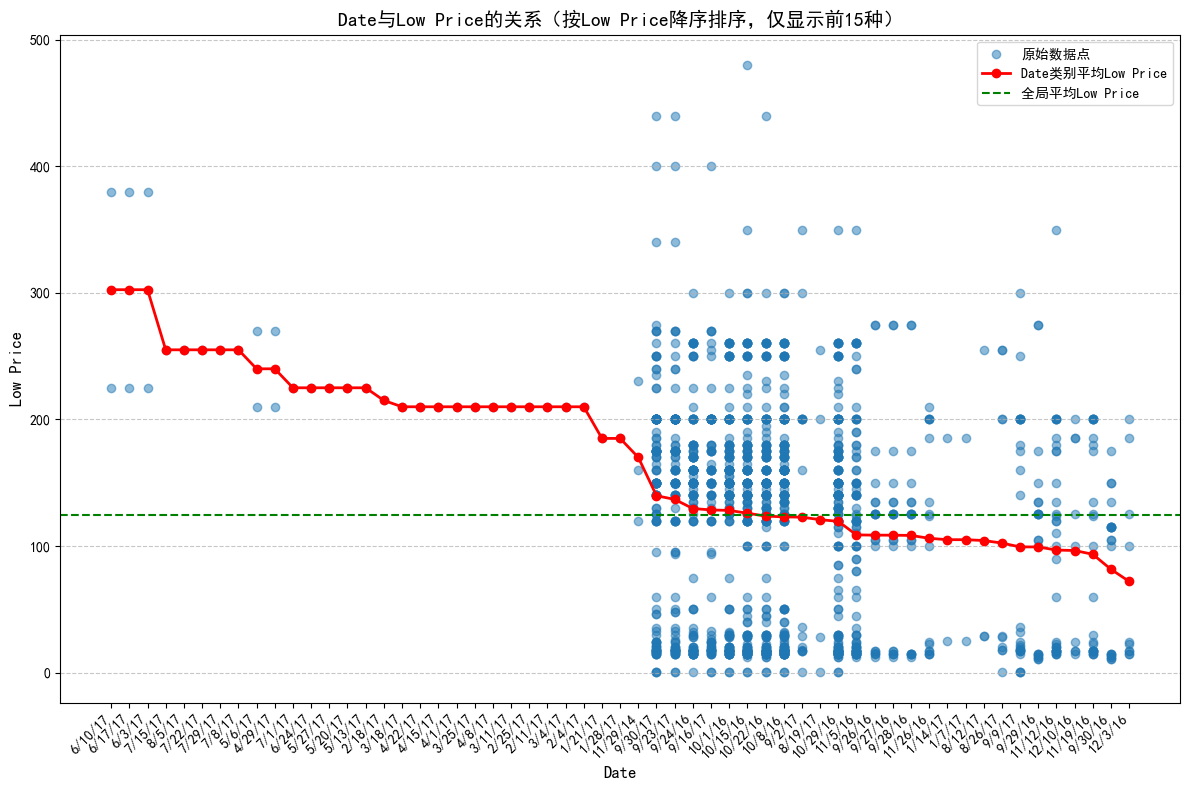

检测到数值型x: Low Price


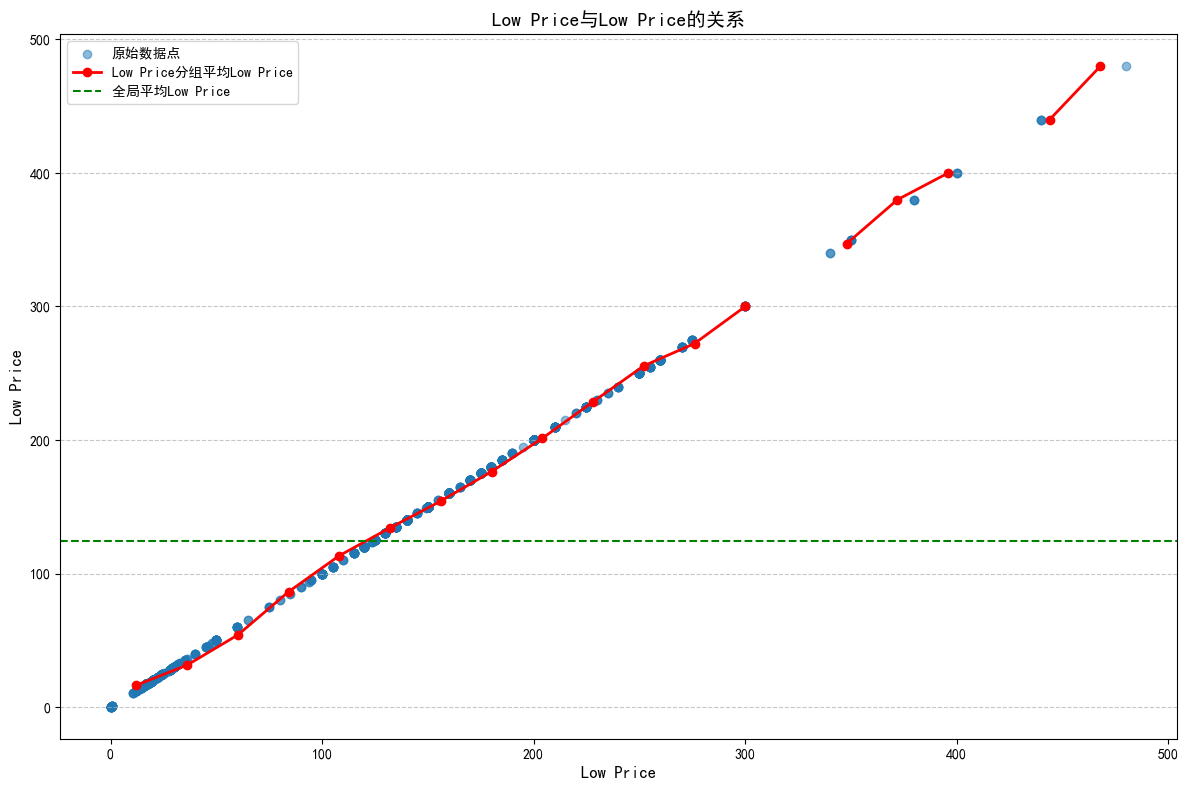

检测到数值型x: High Price


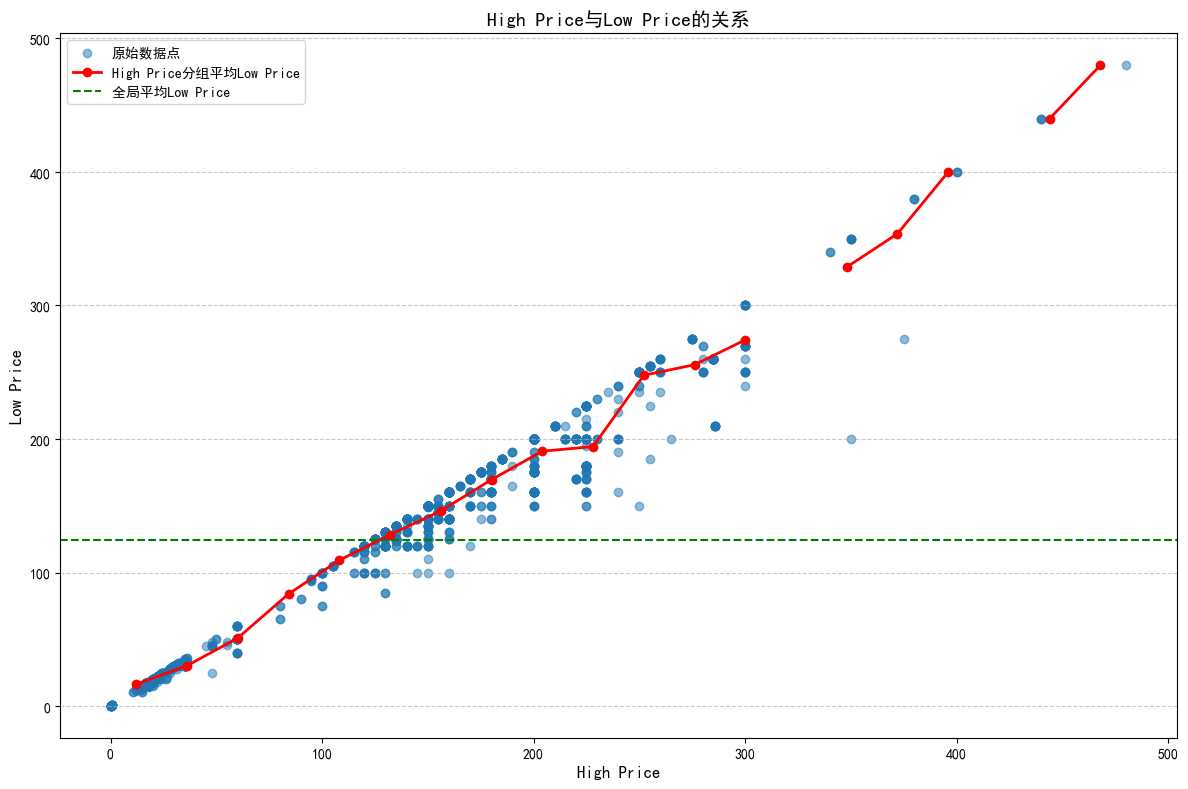

检测到数值型x: Mostly Low


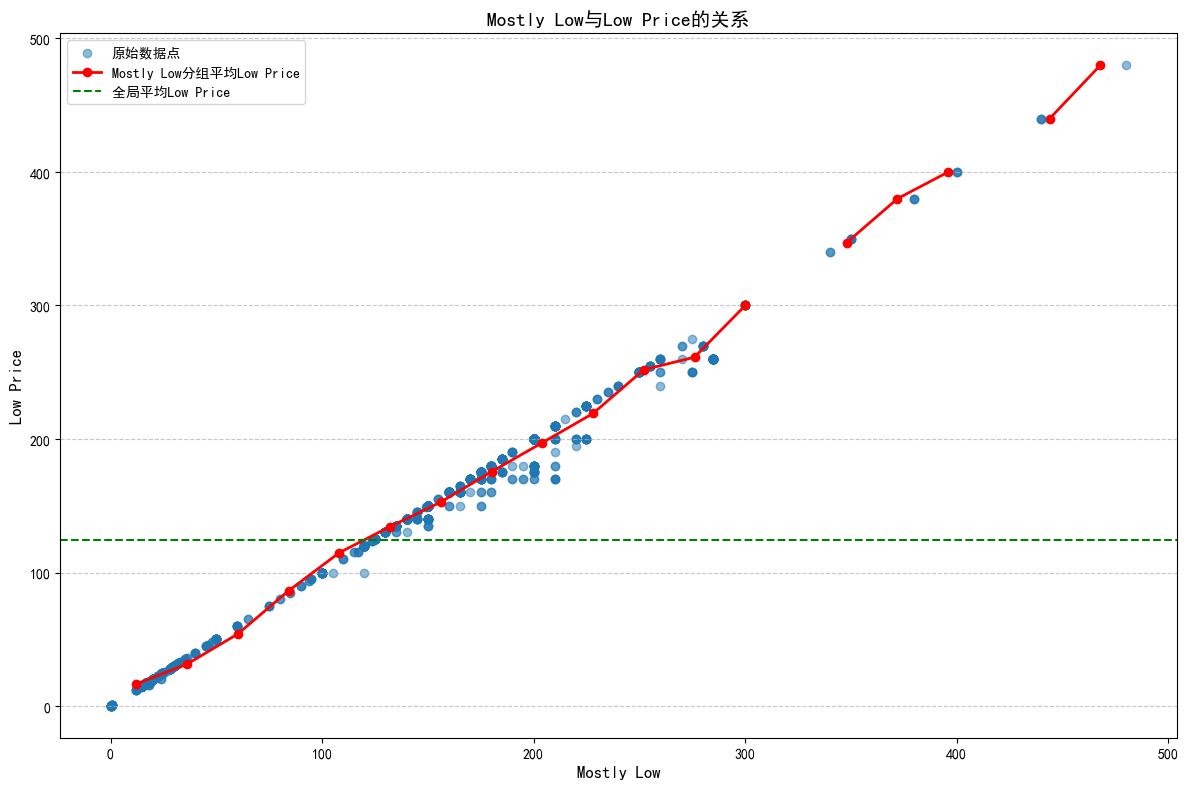

检测到数值型x: Mostly High


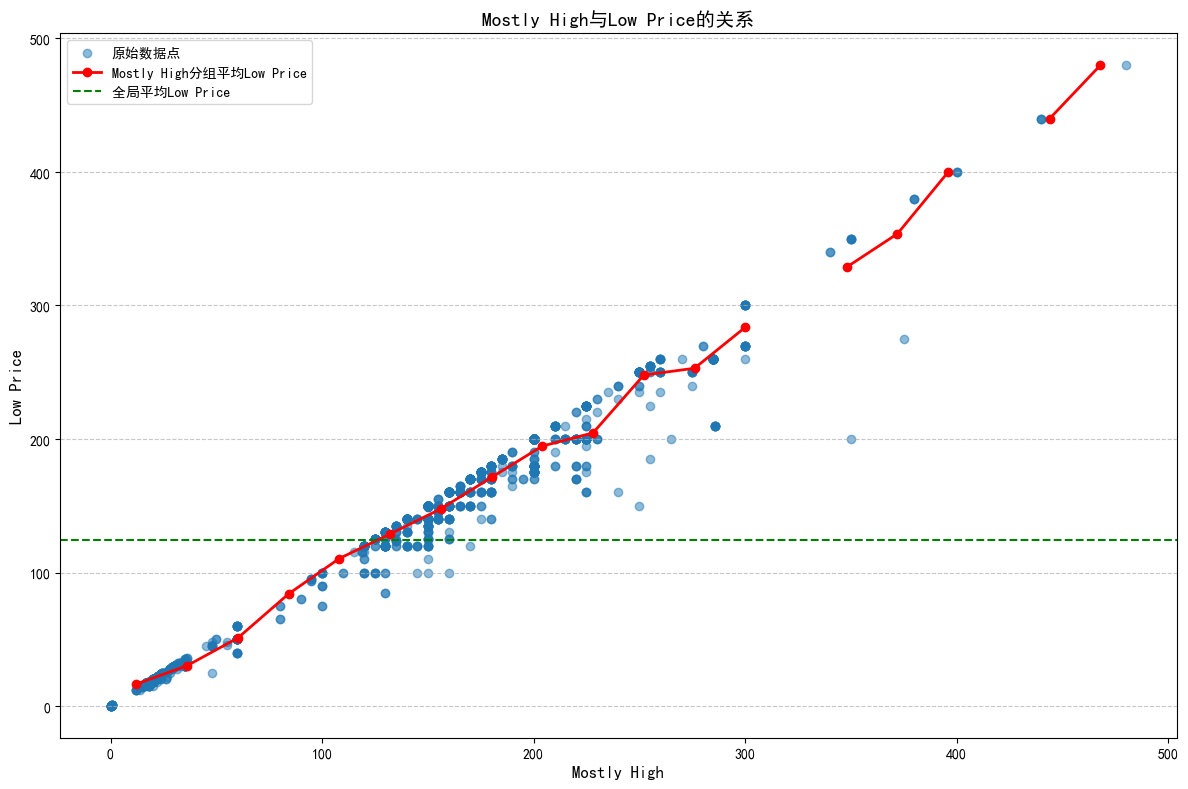

检测到分类型x: Origin


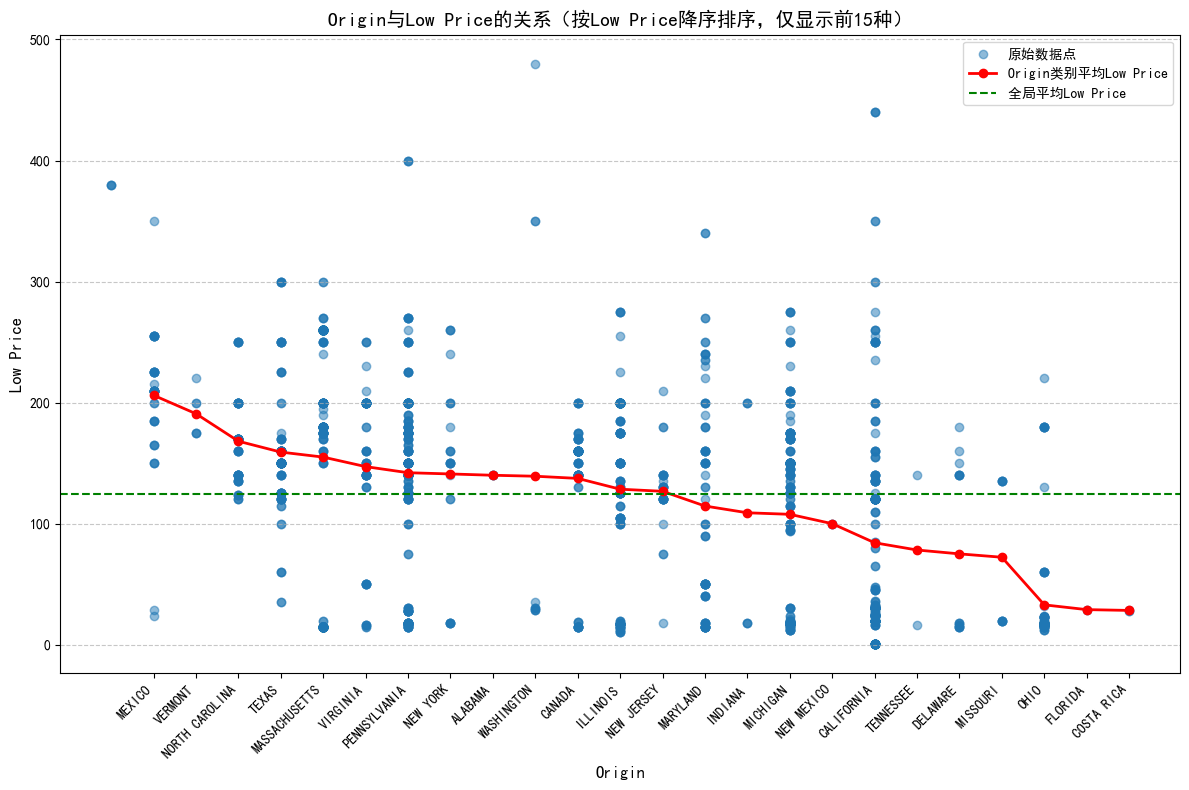

检测到分类型x: Origin District


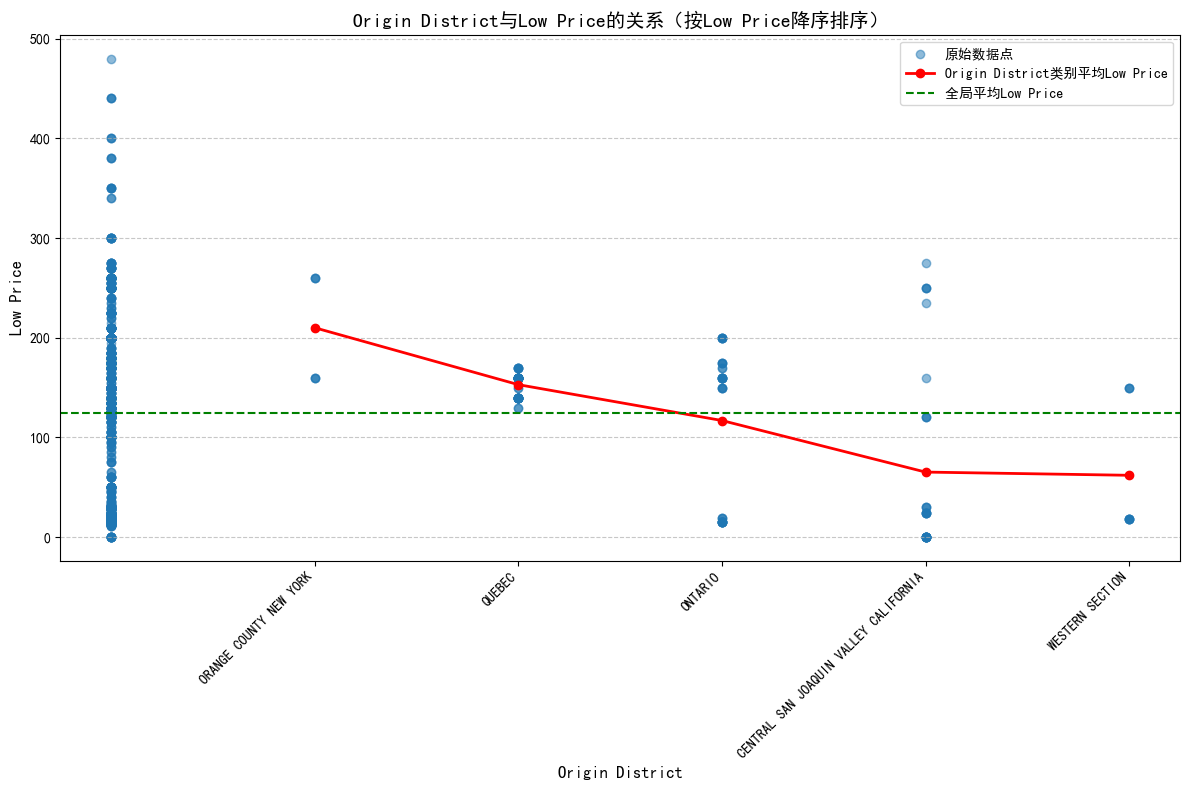

检测到分类型x: Item Size


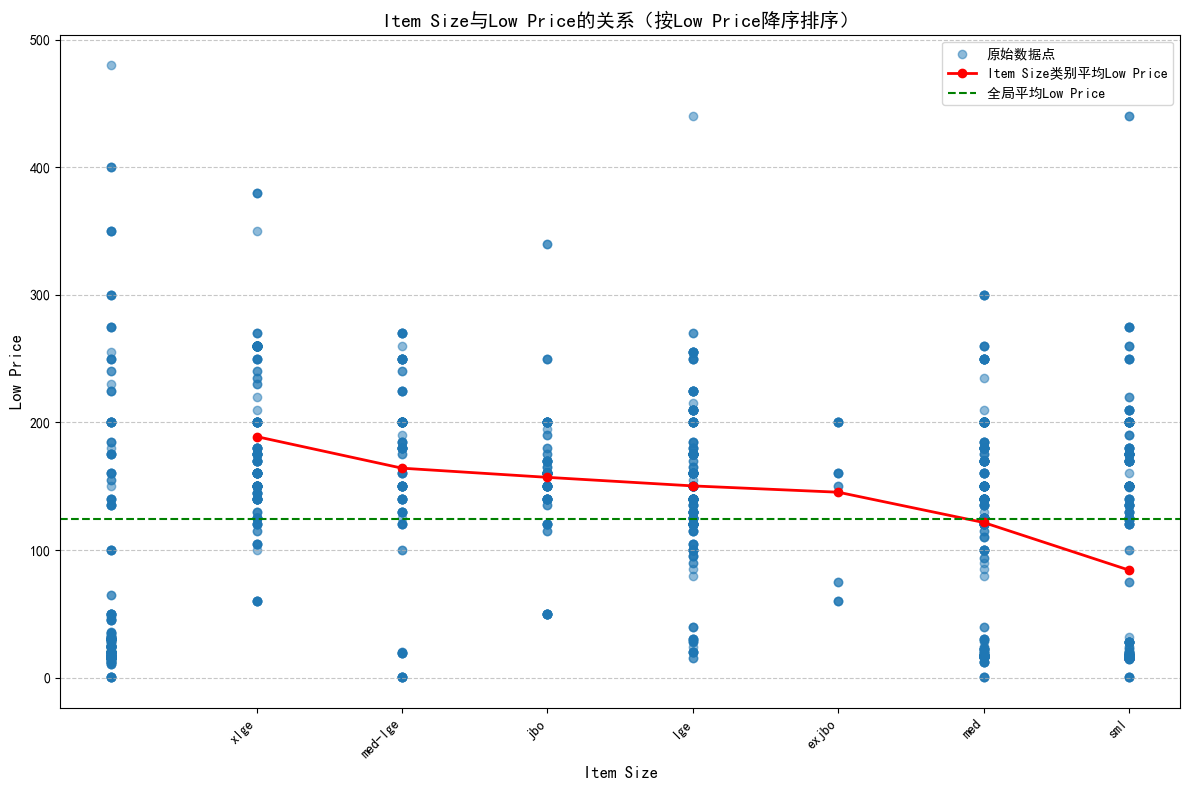

检测到分类型x: Color


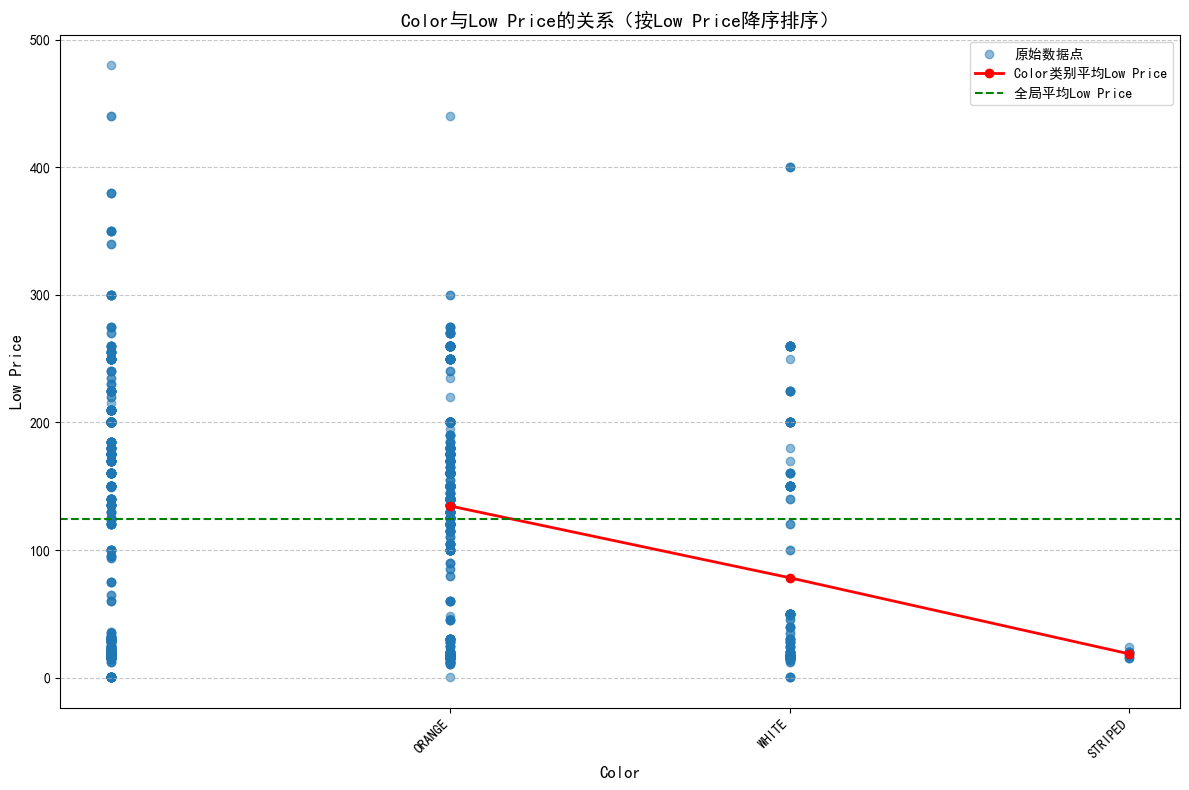

⚠⚠⚠⚠列名 'Environment' 中数据为空!⚠⚠⚠⚠
检测到分类型x: Unit of Sale


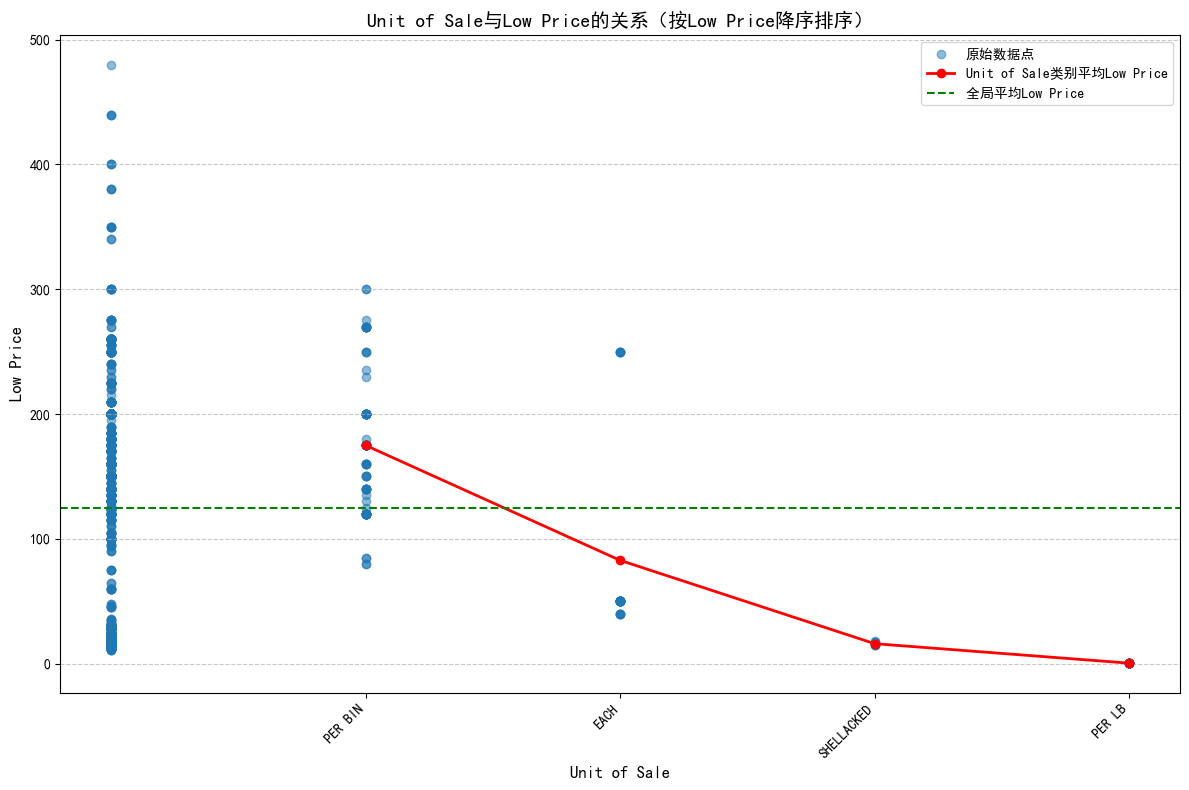

⚠⚠⚠⚠列名 'Quality' 中数据为空!⚠⚠⚠⚠
⚠⚠⚠⚠列名 'Condition' 中数据为空!⚠⚠⚠⚠
⚠⚠⚠⚠列名 'Appearance' 中数据为空!⚠⚠⚠⚠
⚠⚠⚠⚠列名 'Storage' 中数据为空!⚠⚠⚠⚠
⚠⚠⚠⚠列名 'Crop' 中数据为空!⚠⚠⚠⚠
检测到分类型x: Repack


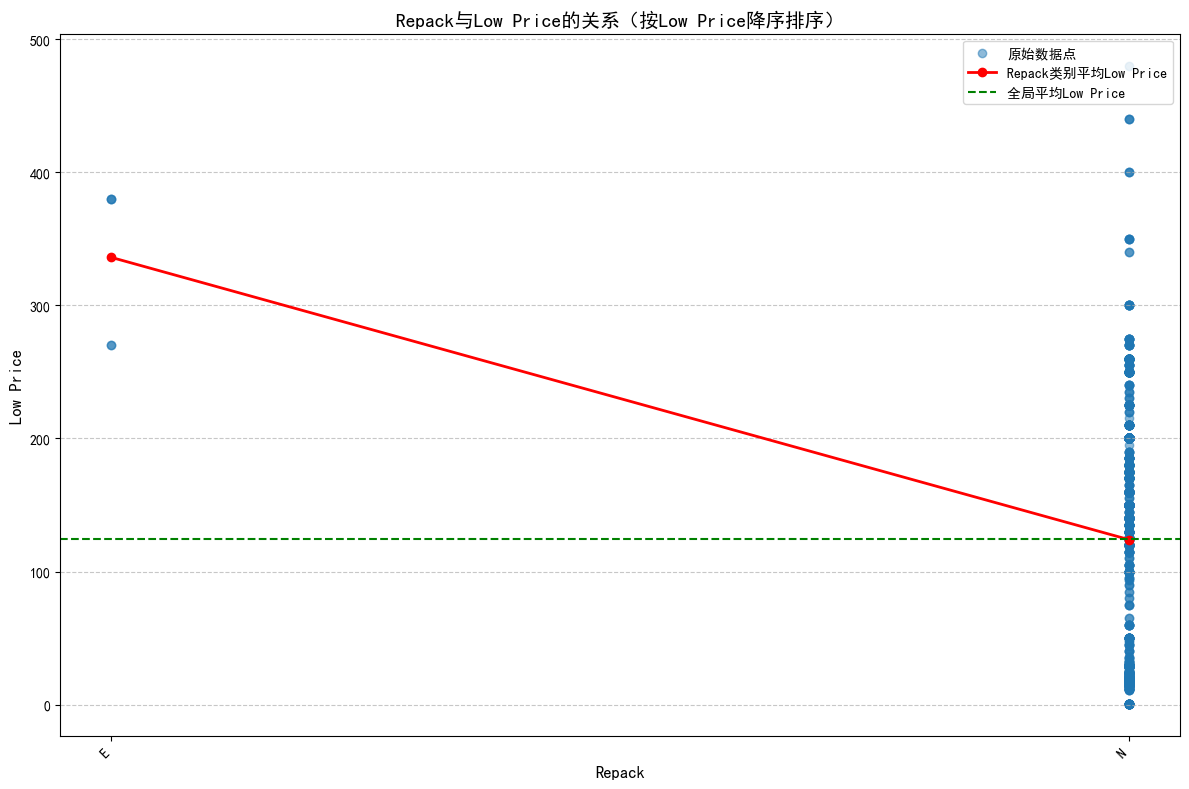

⚠⚠⚠⚠列名 'Trans Mode' 中数据为空!⚠⚠⚠⚠
⚠⚠⚠⚠列名 'Unnamed: 24' 中数据为空!⚠⚠⚠⚠
检测到分类型x: Unnamed: 25


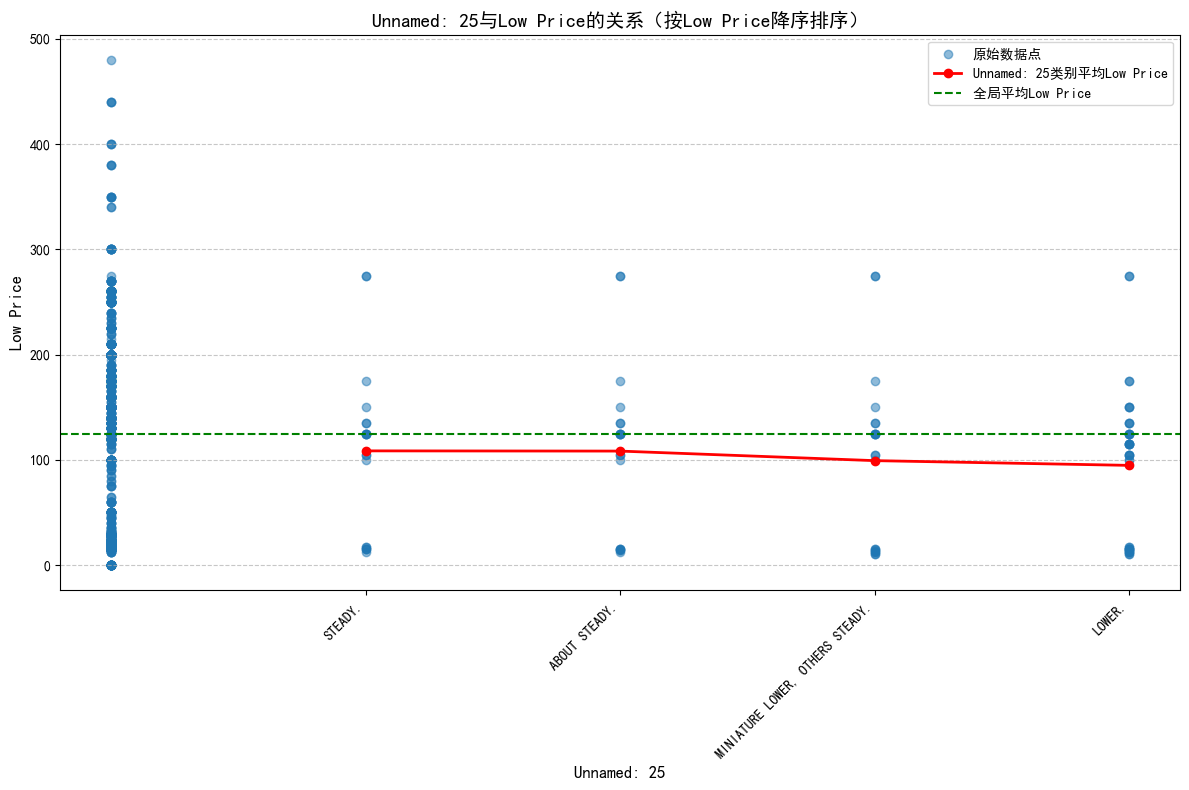

In [49]:
# 假设df是你的数据框
import pandas as pd
data =pd.read_csv(r'../data/US-pumpkins.csv')
for i in data.columns:
    # auto_eda(data,i)
    data_y_xi_show(data,i,'Low Price')
